<center>
# Sberbank Data Science Contest 2017: Problem A
<img src="img/task_a.png" width=400px; height=400px>
<h4 align='right'>
Автор решения: Александр Желубенков (topspin26), 1 место.
</h4>

<h2 align='center'>Data Preparation & Feature Engineering</h2>

## Этапы решения 0-4

* [Этап 0. Чтение и подготовка данных](#Этап-0.-Чтение-и-подготовка-данных)
  * [Морфологический анализ, библиотека pymystem3](#Морфологический-анализ,-библиотека-pymystem3)
  * <a href="#Частота(idfs)-для-слов(триграмм)-из-параграфов/вопросов">Частота(idfs) для слов(триграмм) из параграфов/вопросов</a>
<div style='margin:10px'></div>
* [Этап 1. Построение факторов для вопроса](#Этап-1.-Построение-факторов-для-вопроса)
 * [Количество повторений вопроса](#Количество-повторений-вопроса)
 * [Встречаемость граммем](#Встречаемость-граммем)
 * [Искусственные повторения слов/словосочетаний](#Искусственные-повторения-слов/словосочетаний)
 * [Слова с большой буквы](#Слова-с-большой-буквы)
 * [Последнее слово вопроса и другие простые текстовые факторы](#Последнее-слово-вопроса-и-другие-простые-текстовые-факторы)
 * [Количество повторов слов/словосочетаний](#Количество-повторов-слов/словосочетаний)
 * [Проверка грамматики с помощью LanguageTool](#Проверка-грамматики-с-помощью-LanguageTool)
 * [Наибольшая общая подстрока вопроса и всех параграфов](#Наибольшая-общая-подстрока-вопроса-и-всех-параграфов)
 * [Однородность вопроса](#Однородность-вопроса)
   * [на основании word-paragraphs и word-questions представлений](#Однородность-вопроса-на-основании-word-paragraphs-и-word-questions-представлений)
   * [на основании word-words представления](#Однородность-вопроса-на-основании-word-words-представления)
   * [на основании предобученных w2v-embeddings](#Однородность-вопроса-на-основании-предобученных-w2v-embeddings)
<div style='margin:10px'></div> 
 * [Повторы суффиксов, префиксов](#Повторы-суффиксов,-префиксов) 
 * [Встречаемость граммем в параграфах](#Встречаемость-граммем-в-параграфах)
<div style='margin:10px'></div>
* [Этап 2. Исправление опечаток в вопросе](#Этап-2.-Исправление-опечаток-в-вопросе)
<div style='margin:10px'></div>
* [Этап 3. Построение факторов для пары параграф-вопрос](#Этап-3.-Построение-факторов-для-пары-параграф-вопрос)
 * [ Схожесть вопроса параграфу](#Схожесть-вопроса-параграфу)
 * [Однородность слов вопроса и параграфа](#Однородность-слов-вопроса-и-параграфа)
   * [на основании word-paragraphs и word-questions представлений](#Однородность-слов-вопроса-и-параграфа-на-основании-word-paragraphs-и-word-questions-представлений)
   * [на основании word-words представления](#Однородность-слов-вопроса-и-параграфа-на-основании-word-words-представления)
   * [на основании предобученных w2v-embeddings](#Однородность-слов-вопроса-и-параграфа-на-основании-предобученных-w2v-embeddings)
<div style='margin:5px'></div> 
 * [Наибольшая общая подстрока вопроса и параграфа](#Наибольшая-общая-подстрока-вопроса-и-параграфа)
 * [Ранги параграфа для вопроса и вопроса для параграфа](#Ранги-параграфа-для-вопроса-и-вопроса-для-параграфа)
 * [Вопросительные/последние слова/словосочетания + LabelEncoding на основании макс. схожести](#Вопросительные/последние-слова/словосочетания-+-LabelEncoding-на-основании-макс.-схожести)
<div style='margin:10px'></div>
* [Этап 4. Построение факторов для параграфа](#Этап-4.-Построение-факторов-для-параграфа)
<div style='margin:10px'></div>

(в другой тетрадке)
* Этап 5. Обучение моделей
* Этап 6. Анализ предсказаний

In [6]:
%load_ext autoreload
%autoreload 2

import sys
print(sys.version)
import os
import random
import json
import re
import pandas as pd
import numpy as np
import scipy as sp
import scipy.sparse as sps
from sklearn import metrics
from sklearn.cluster import SpectralClustering
import math
import seaborn as sns
import nltk
import zlib
from collections import Counter
import xgboost as xgb
from Levenshtein import distance

import tqdm
from tqdm import tqdm_notebook

from IPython.display import display

import matplotlib as mpl
import matplotlib.patches as patches
get_ipython().magic('matplotlib inline')
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import HTML

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', -1)

display(HTML(data="""
<style>
    div#notebook-container    { width: 80%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 79%; }
</style>
"""))

sns.set(font_scale = 1.2)

3.5.4 |Anaconda, Inc.| (default, Sep 30 2017, 11:07:29) [MSC v.1900 64 bit (AMD64)]


C:\Users\Alexandr\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
import common_mystem
import common_words
import common_zlib
import language_tool
import lcs
import spelling_corrector
import w2v_info
import words_score
import similarity
import ranks_features

## Этап 0. Чтение и подготовка данных

In [8]:
df_train = pd.read_csv('data/train_task1_latest.csv')
df_test = pd.read_csv('data/sdsj_A_test.csv')
df_train_b = pd.read_csv('data/train_task_b.csv')

In [14]:
df_all = pd.concat([df_train, df_test])
df_all['isTr'] = [1] * len(df_train) + [0] * len(df_test)
indTrain = (df_all['isTr'] == 1)
indTest = (df_all['isTr'] == 0)

In [15]:
df_all.target.value_counts(dropna=False).reset_index()

,index,target
0,0.0,85361
1,NaN,74286
2,1.0,34037


### Морфологический анализ, библиотека pymystem3

In [16]:
import common_mystem

In [17]:
all_paragraphs2mystem, all_questions2mystem = common_mystem.runMystem(df_train, df_test, df_train_b)
print(len(all_paragraphs2mystem), len(all_questions2mystem))

10705 93692
ok
ok
10705 93692


In [18]:
all_pq2mystem = all_paragraphs2mystem.copy()
for e in all_questions2mystem:
     all_pq2mystem[e] = all_questions2mystem[e].copy()

**Обогащаем данные нормализованными текстами с разными условиями:**
 * все нормализованные слова;
 * сохраняем в нормализованных словах заглавную букву, если она была в исходном слове;
 * оставляем только существительные;
 * оставляем только существительные, прилагательные, глаголы и наречия;

In [19]:
%%time
d = dict()
du = dict()
dus = dict()
dusav = dict()
for e in all_questions2mystem:
    d[e] = common_mystem.getMystemText(e, all_questions2mystem)
    du[e] = common_mystem.getMystemText(e, all_questions2mystem, save_upper=True)
    dus[e] = common_mystem.getMystemText(e, all_questions2mystem, filter_pos={'S'})
    dusav[e] = common_mystem.getMystemText(e, all_questions2mystem, filter_pos={'S', 'A', 'V', 'ADV'})
df_all['question_ms'] = df_all.question.map(d)
df_all['question_ms_upper'] = df_all.question.map(du)
df_all['question_ms_S'] = df_all.question.map(dus)
df_all['question_ms_SAV'] = df_all.question.map(dusav)
df_train_b['question_ms'] = df_train_b.question.map(d)

d = dict()
du = dict()
dus = dict()
dusav = dict()
for e in all_paragraphs2mystem:
    d[e] = common_mystem.getMystemText(e, all_paragraphs2mystem)
    du[e] = common_mystem.getMystemText(e, all_paragraphs2mystem, save_upper=True)
    dus[e] = common_mystem.getMystemText(e, all_paragraphs2mystem, filter_pos={'S'})
    dusav[e] = common_mystem.getMystemText(e, all_paragraphs2mystem, filter_pos={'S', 'A', 'V', 'ADV'})
df_all['paragraph_ms'] = df_all.paragraph.map(d)
df_all['paragraph_ms_upper'] = df_all.paragraph.map(du)
df_all['paragraph_ms_S'] = df_all.paragraph.map(dus)
df_all['paragraph_ms_SAV'] = df_all.paragraph.map(dusav)
df_train_b['paragraph_ms'] = df_train_b.paragraph.map(d)

Wall time: 18.5 s


In [21]:
with open('data/mystem/question_ms.txt', 'w', encoding='utf-8') as fout:
    for i,e in enumerate(sorted(all_questions2mystem)):
        fout.write('q' + str(i) + '\t' + e + '\t' + common_mystem.getMystemText(e, all_questions2mystem))
with open('data/mystem/paragraph_ms.txt', 'w', encoding='utf-8') as fout:
    for i,e in enumerate(sorted(all_paragraphs2mystem)):
        fout.write('p' + str(i) + '\t' + e + '\t' + common_mystem.getMystemText(e, all_paragraphs2mystem))        

### Частота(idfs) для слов(триграмм) из параграфов/вопросов

In [20]:
import common_words

In [21]:
idfs_paragraphs = common_words.\
    calculate_idfs([common_mystem.getMystemText(e, all_paragraphs2mystem) for e in all_paragraphs2mystem])
idfs_questions = common_words.\
    calculate_idfs([common_mystem.getMystemText(e, all_questions2mystem) for e in all_questions2mystem])

A Jupyter Widget


10690


A Jupyter Widget


93595


In [22]:
counter_paragraphs = common_words.\
    calculate_counter([common_mystem.getMystemText(e, all_paragraphs2mystem) for e in all_paragraphs2mystem])

A Jupyter Widget

In [23]:
idfs_paragraphs_3chars = common_words.\
    calculate_idfs_chars([common_mystem.getMystemText(e, all_paragraphs2mystem) for e in all_paragraphs2mystem])
idfs_questions_3chars = common_words.\
    calculate_idfs_chars([common_mystem.getMystemText(e, all_questions2mystem) for e in all_questions2mystem])

A Jupyter Widget


10690


A Jupyter Widget


93595


In [24]:
print(len(idfs_questions), len(set(list(idfs_paragraphs.keys()) + list(idfs_questions.keys()))))
print(np.percentile(list(idfs_paragraphs.values()), 10), np.percentile(list(idfs_questions.values()), 10))

42305 72812
6.6380066744 8.04553486057


In [25]:
with open('data/idfs_paragraphs.txt', 'w', encoding='utf-8') as fout:
    for k,v in sorted(idfs_paragraphs.items(), key=lambda x: x[0]):
        fout.write(k + '\t' + str(v) + '\n')
with open('data/idfs_questions.txt', 'w', encoding='utf-8') as fout:
    for k,v in sorted(idfs_questions.items(), key=lambda x: x[0]):
        fout.write(k + '\t' + str(v) + '\n')        

** Количественный анализ вопросов и параграфов**

В пересечении множества вопросов из train и из test находятся 7 вопросов

In [28]:
print(len(set(df_test.question)), len(set(df_train.question)), len(set(df_test.question) & set(df_train.question)))
print(set(df_test.question) & set(df_train.question))

43340 38868 7
{'Когда возникли взаимовыгодные взаимоотношения пчёл и орхидей?', 'Где находится копулятивный орган самцов змей?', 'Кому подражает парусник Papilio agestor?', 'Кто опыляет инжир?', 'Что такое АТФ?', 'Чем контролируется яркая окраска крыльев некоторых бабочек?', 'Что прилипает к голове или груди самца во время посещения цветка?'}


** Параграфы в train и test не пересекаются**

In [29]:
len(set(df_test.paragraph)), len(set(df_train.paragraph)), len(set(df_test.paragraph) & set(df_train.paragraph))

(1627, 9078, 0)

** Параграфы из train выборок задач A и B совпадают, вопросов в train выборке задачи B на ~11.000 больше**

In [30]:
print(len(set(df_train.question) & set(df_train_b.question)), len(set(df_train.question) | set(df_train_b.question)))
print(len(set(df_train.paragraph) & set(df_train_b.paragraph)), len(set(df_train.paragraph) | set(df_train_b.paragraph)))

38868 50361
9078 9078


## Этап 1. Построение факторов для вопроса

In [26]:
df_all_questions = df_all[['question', 'question_ms', 'question_ms_upper', 'question_id', 'isTr']].drop_duplicates()
df_all_questions = df_all_questions.reset_index(drop=True)

In [27]:
print(len(df_all_questions))

82211


In [28]:
features_dict = dict()

### Количество повторений вопроса

Было замечено, что синтетические вопросы НЕ повторяются, т.е. вопрос может быть синтетическим только если он один раз встретился в данных

Пометим все вопросы, которые встречаются более одного раза флагом *isTr1*

In [29]:
c = Counter()
c.update(df_all.question)
df_all_questions['qCnt'] = df_all_questions.question.map(c)
df_all_questions['isTr1'] = df_all_questions.isTr
df_all_questions.loc[df_all_questions.qCnt > 1, 'isTr1'] = 1

### Встречаемость граммем

** Преобразуем тексты вопросов, используя граммемы, выделенные pymystem3**

* Части речи; биграммы частей речи (текст заменяется на последовательность частей речи слов)
* Пары "Падеж сущ. + ближайший предлог, встретившийся ДО сущ."
* Падежи сущ. и прилаг; биграммы "Падеж сущ/прилаг + Падеж сущ/прилаг"
* Число сущ, прилаг, глаг, мест-сущ, мест-прилаг; биграммы последовательных чисел (мн или ед)
* Род сущ, прилаг, глаг, мест-сущ, мест-прилаг; биграммы последовательных родов (муж, ср, жен)
* Прочие обозначения, выделяемые pymystem3 (гео, имя, фам, ...); биграммы последовательных обозначений

In [35]:
%%time
df_all_questions['question_pos'] = df_all_questions.question.\
    apply(lambda x: common_mystem.getMystemPartOfSpeech(x, all_questions2mystem, ngr=2))
    
df_all_questions['question_pr_s_case'] = df_all_questions.question.\
    apply(lambda x: common_mystem.getMystemPR_S_CASE(x, all_questions2mystem))
    
df_all_questions['question_a_s_case'] = df_all_questions.question.\
    apply(lambda x: common_mystem.calcA_S_CASE(all_questions2mystem[x]))

df_all_questions['question_a_v_s_CH'] = df_all_questions.question.\
    apply(lambda x: common_mystem.calcA_V_S(all_questions2mystem[x], col='CH', filter_pos={'A', 'V', 'S', 'SPRO', 'APRO'}))
    
df_all_questions['question_a_v_s_R'] = df_all_questions.question.\
    apply(lambda x: common_mystem.calcA_V_S(all_questions2mystem[x], col='R', filter_pos={'A', 'V', 'S', 'SPRO', 'APRO'}))    
    
df_all_questions['question_a_v_s_OTH'] = df_all_questions.question.\
    apply(lambda x: common_mystem.calcA_V_S(all_questions2mystem[x], col='OTH', isE=True)) 

Wall time: 18.4 s


In [36]:
df_all_questions.iloc[22, :].transpose().reset_index()

,index,22
0,question,"Как звали греческого воина, который в 490 году до н. э. после битвы при Марафоне пробежал, не останавливаясь, от Марафона до Афин, чтобы возвестить о победе греков?"
1,question_ms,"как звать греческий воин, который в 490 год до н. э. после битва при марафон пробежать, не останавливаться, от марафон до афины, чтобы возвещать о победа греков?\n"
2,question_ms_upper,"Как звать греческий воин, который в 490 год до н. э. после битва при Марафон пробежать, не останавливаться, от Марафон до Афины, чтобы возвещать о победа греков?\n"
3,question_id,13550
4,isTr,1
5,qCnt,27
6,isTr1,1
7,question_pos,ADVPRO V A S OTHER APRO PR NUMB S PR S OTHER S OTHER PR S PR S V OTHER PART V OTHER PR S PR S OTHER CONJ V PR S S OTHER OTHER ADVPRO_V V_A A_S S_OTHER OTHER_APRO APRO_PR PR_NUMB NUMB_S S_PR PR_S S_OTHER OTHER_S S_OTHER OTHER_PR PR_S S_PR PR_S S_V V_OTHER OTHER_PART PART_V V_OTHER OTHER_PR PR_S S_PR PR_S S_OTHER OTHER_CONJ CONJ_V V_PR PR_S S_S S_OTHER
8,question_pr_s_case,_вин в_дат до_пр до_пр после_вин при_пр от_род до_род о_пр о_им
9,question_a_s_case,вин вин Aвин_Sвин дат пр пр Sпр_Sпр вин пр род род пр им Sпр_Sим


** Вычислим количество и долю выделенных граммем, которые встречаются не менее чем в 50 различных вопросах **

In [37]:
def addFeatures(df_all_questions, fname, trsh=20):
    f = []
    poses = Counter()
    poses_te = Counter()
    poses_tr = Counter()
    for e1,e2 in zip(df_all_questions[fname], df_all_questions['isTr1']):
        poses.update(set(e1.split(' ')))
        if e2 == 0:
            poses_te.update(set(e1.split(' ')))
        else:
            poses_tr.update(set(e1.split(' ')))
    for i,e in enumerate(poses):
#        print(i, e, poses[e])
        if poses[e] >= 50:
            df_all_questions[fname + '_{}_rel'.format(e)] = df_all_questions[fname].apply(lambda x: x.split(' ').count(e) / len(x.split(' ')))
            df_all_questions[fname + '_{}_cnt'.format(e)] = df_all_questions[fname].apply(lambda x: x.split(' ').count(e))
            f += [fname + '_{}_rel'.format(e), fname + '_{}_cnt'.format(e)]
    return f

In [38]:
%%time
for e in ['question_pos', 'question_pr_s_case', 'question_a_s_case', 'question_a_v_s_CH', 'question_a_v_s_R', 'question_a_v_s_OTH']:
    features_dict[e] = addFeatures(df_all_questions, e)
    print(e, len(features_dict[e]))

question_pos 398
question_pr_s_case 330
question_a_s_case 250
question_a_v_s_CH 182
question_a_v_s_R 270
question_a_v_s_OTH 54
Wall time: 3min 8s


In [39]:
sum([len(e) for e in features_dict.values()])

1484

Как видим, факторов получилось достаточно много (1484), в дальнейшем будет использована лишь часть из них.

### Искусственные повторения слов/словосочетаний

Было замечено, что в синтетических вопросах достаточно часто друг за другом могут идти одинаковые слова/словосочетания

В параграфах и человеческих вопросах такие повторения НЕ встречаются, за исключением одного случая

In [40]:
def findBad(data, is_print=False):
    bad1 = list()
    bad2 = list()
    bad3 = list()
    for e in data:
        result = ''.join(c.lower() for c in e if c.isalpha() or c.isdigit() or c in {'—', ' ', '.', '(', ')', '+'}).split()
        fl = 0
        if fl == 0:
            for i in range(len(result) - 2):
                if result[i] != '' and result[i] == result[i + 1] and result[i] == result[i + 2] and result[i] != 'damned' and \
                   result[i] != 'oi'  and result[i] != '000':
                    bad1.append(e)
                    if is_print is True:
                        if i + 3 < len(result) and result[i + 3] != result[i]:
                            #print(result[max(i - 4, 0):min(i+7, len(result))])
                            print(result[i], e)
                    break
        if fl == 0:
            for i in range(len(result) - 5):
                if result[i] != '' and result[i + 1] != '' and result[i] != result[i + 1] and \
                    result[i] == result[i + 2] == result[i + 4] and result[i + 1] == result[i + 3] == result[i + 5]:
                    bad2.append(e)
                    fl = 1
                    break
        if fl == 0:
            for i in range(len(result) - 5):
                if result[i] != '' and result[i + 1] != '' and result[i + 2] != '' and result[i] != result[i + 1] and result[i + 1] != result[i + 2] and \
                    result[i] == result[i + 3] and result[i + 1] == result[i + 4] and result[i + 2] == result[i + 5] and \
                    result[i] + result[i + 1] + result[i + 2] != 'досихпор' and result[i] != '—':
                    #print(result[i:i + 6])
                    bad3.append(e)
                    fl = 1
                    break
        if fl == 0:
            for i in range(len(result) - 7):
                if result[i] != '' and result[i + 1] != '' and result[i + 2] != '' and result[i + 3] != '' and \
                    result[i] != result[i + 1] and result[i + 1] != result[i + 2] and result[i + 2] != result[i + 3] and \
                    result[i] == result[i + 4] and result[i + 1] == result[i + 5] and result[i + 2] == result[i + 6] and result[i + 3] == result[i + 7]:
                    #print(e)
                    bad3.append(e)
                    fl = 1
                    break
    return bad1, bad2, bad3

** Повторения слов среди всех параграфов **

Найден один подозрительный случай "мастерам спорта СССР, мастерам спорта СССР"

In [41]:
badp1, badp2, badp3 = findBad(list(set(all_paragraphs2mystem.keys())))
print(len(badp1), len(set(badp1)))
print(len(badp2), len(set(badp2)))
print(len(badp3), len(set(badp3)))
badp3

0 0
0 0
1 1


['Пенсии за спортивные достижения и выслугу лет были установлены Постановлением Совета Министров СССР, ВЦСПС и ЦК ВЛКСМ от 2 августа 1988 года № 945 О совершенствовании управления футболом, другими игровыми видами спорта и дополнительных мерах по упорядочению содержания команд и спортсменов по основным видам спорта . Согласно принятому в феврале 1989 года Порядку назначения и выплаты пенсий за выслугу лет заслуженным мастерам спорта СССР, мастерам спорта СССР международного класса — членам сборных команд СССР эти пенсии назначались при общем стаже работы не менее 20 лет заслуженным мастерам спорта СССР и мастерам спорта СССР международного класса, состоявшим в штате команд мастеров не менее 10 лет, в том числе в сборных командах СССР, или не менее 6 лет в составе сборных команд СССР .']

** Повторения среди всех человеческих вопросов **

In [42]:
badq1, badq2, badq3 = findBad(list(df_all_questions.loc[df_all_questions.isTr1 == 1, 'question']))
print(len(badq1), len(set(badq1)))
print(len(badq2), len(set(badq2)))
print(len(badq3), len(set(badq3)))

0 0
0 0
0 0


** Повторения среди всех тестовых вопросов, которые потенциально могут быть синтетическими **

In [43]:
bad1, bad2, bad3 = findBad(df_test['question'], is_print=False)
print(len(bad1), len(set(bad1)))
print(len(bad2), len(set(bad2)))
print(len(bad3), len(set(bad3)))

bad1 = set(bad1)
bad2 = set(bad2)
bad3 = set(bad3)
bad = bad1 | bad2 | bad3
print(len(bad), len(bad1), len(bad2), len(bad2 - bad1))
for e in sorted(bad)[:3] + sorted(bad)[-3:]:
    print(e)

1499 1499
716 716
1781 1781
3882 1499 716 672
Ванглийский традиции за политической культуре средневековой европы категория книга книга книга опубликована книга опубликована монография с политической культуре средневековой европы?
Вкаких года работали в популярных продуктов работали в популярных продуктов работали в популярных продуктов работали в популярных продуктов?
Вкакой материал хорошо датируется х xi веками за реку кура в жилых районов минска исторический район обсуждение грозный сити обсуждение грозный сити 2 местами является минимальным за реку минчио значило?
Что ясно, это делают делают делают делают выбор, принимать эти ценности, сделать?
Шасси каких команды никогда не играли большую роль играли большую роль играли большую роль?
Широко распространённое разговорное название широко распространён широко распространён широко распространён широко известны случаи межвидового скрещивания?


** Еще одним сигналом к наличию повторов может служить степень сжатия строки **

In [30]:
df_all_questions['question_compression_score'] = df_all_questions['question'].\
    apply(lambda x: len(zlib.compress(x.encode('utf-8'))) / len(x.encode('utf-8')))
features_dict['question_compression_score'] = ['question_compression_score']

Посмотрим на распределение данного фактора среди явно человеческих вопросов и среди тестовых вопросов, которые потенциально могут быть синтетическими 

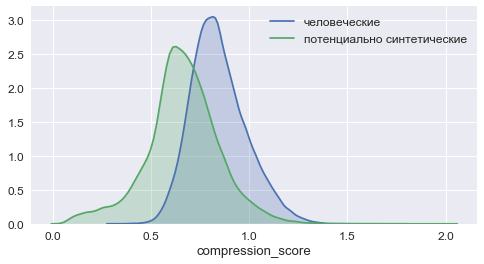

In [31]:
plt.figure(figsize=(8, 4))
sns.kdeplot(df_all_questions[df_all_questions.isTr1 == 1].question_compression_score, shade=True, shade_lowest=False, label='человеческие')
sns.kdeplot(df_all_questions[df_all_questions.isTr1 == 0].question_compression_score, shade=True, shade_lowest=False, label='потенциально синтетические')
plt.legend()
plt.xlabel('compression_score')
plt.show()

### Слова с большой буквы

Было замечено, что в синтетических вопросах слова "с большой буквы" встречаются редко(если отбросить первое слово). В исключительных случаях они все же встречаются, но располагаются ближе к началу вопроса.

Это наблюдение можно использовать двумя способами:

* если в вопросе встретилось слово "с большой буквы", тогда вопрос скорее НЕ может быть синтетическим
* если в вопросе встречаются слова, которые в параграфах часто пишутся "с большой буквы"(например, слово Россия), то вопрос скорее всего синтетический

In [51]:
def getLastUpperCase(s):
    for i in range(len(s) - 1, -1, -1):
        if s[i].isupper():
            return i / len(s)
    return -1

# Здесь была допущена ошибка: score нужно считать только по словам, написанным с маленькой буквы
# Или вычитать значения, если слово, которое должно быть написано с большой буквы, написано корректно
def calcUpperSumScore(s, upperScore):
    res = 0
    for word in re.split("[\W^\d]+", s)[1:]:
        w = word.strip().lower()
        v = upperScore.get(w, [-1, -1])
        res += (v[1] + 1) / (v[0] + 2)
    return res

# Здесь была допущена ошибка: score нужно считать только по словам, написанным с маленькой буквы
def calcUpperMaxScore(s, upperScore):
    res = 0
    for word in re.split("[\W^\d]+", s)[1:]:
        w = word.strip().lower()
        v = upperScore.get(w, [-1, -1])
        res = max(res, (v[1] + 1) / (v[0] + 2))
    return res

4 фактора:
* наличие слова с большой буквы
* относительная позиция слова с большой буквы
* сумма по всем словам "вероятности" написания слова с большой буквы
* максимум по всем словам "вероятности" написания слова с большой буквы

In [52]:
def calcUpperFeatures(df_all, df_all_questions, features_dict):
    upperScore = dict()
    for e in set(df_all.paragraph_ms_upper):
        for s in e.split('.'):
            s = s.strip()
            ind = 1
            if len(s) <= 3:
                ind = 0
            for word in re.split("[\W^\d]+", s)[ind:]:
                w = word.strip().lower()
                if len(w) == 0:
                    continue
                if w not in upperScore:
                    upperScore[w] = [0, 0]
                upperScore[w][0] += 1
                if word.istitle():
                    upperScore[w][1] += 1

    df_all_questions['isUpperCase'] = df_all_questions['question'].apply(lambda x: x[1:].lower() != x[1:]).astype(int)
    df_all_questions['relLastUpperCase'] = df_all_questions['question'].apply(lambda x: getLastUpperCase(x))
    df_all_questions['upperSumScore'] = df_all_questions.question_ms_upper.apply(lambda x: calcUpperSumScore(x, upperScore))
    df_all_questions['upperMaxScore'] = df_all_questions.question_ms_upper.apply(lambda x: calcUpperMaxScore(x, upperScore))
                    
    features_dict['upper'] = ['isUpperCase', 'relLastUpperCase', 'upperSumScore', 'upperMaxScore']
    
    return upperScore

In [53]:
upperScore = calcUpperFeatures(df_all, df_all_questions, features_dict)

In [54]:
upperScore = pd.DataFrame(upperScore).transpose()
upperScore[2] = (upperScore[1] + 1) / (upperScore[0] + 2)
upperScore.sort_values(2, ascending=False).head(5)

,0,1,2
россия,935,935,0.998933
англия,264,264,0.996241
италия,247,247,0.995984
европа,477,476,0.995825
америка,233,233,0.995745


In [55]:
df_all_questions.loc[df_all_questions.isTr1 == 0, ['question', 'upperMaxScore']].sort_values('upperMaxScore', ascending=False).head(2)

,question,upperMaxScore
76800,"Чем служат источником возникновения земледелия в культурных злаков пшеницы, риса, кукурузы и регионов россии добывают бериллий в растительных?",0.998933
59265,Сколько структурных подразделений электроснабжения социальная сфера в долгосрочную сохранность от копирования конкурентами и преимущества вступления россии?,0.998933


### Последнее слово вопроса и другие простые текстовые факторы

Было замечено, что если вопрос заканчивается на однобуквенное слово, то вероятнее он синтетический

In [56]:
def getFinishSymbols(e, cnt):
    t = e.rstrip().replace(' ?', '?').replace('?', '').replace('.', '').replace(')', '')
    t = t.replace(' и т д', '').replace(' и т п', '')
    t = t.replace(' н э', '')
    t = t.replace(' ю ш', '').replace(' с ш', '').replace(' в д', '').replace(' з д', '')
    t = t.replace(' и др', '')
    t = t.replace(' р х', '')
    t = t.rstrip()
    if len(t) > 2 and t[-1] in {'г', 'м'} and t[-3].isdigit():
        t = t[:-2] + t[-1]
    t = t.rstrip()[-cnt:].lstrip()
    return t

7 факторов:

* Наличие повторов
* Окончание вопроса на однобуквенное слово
* Доля уникальных слов в вопросе
* Количество слов в вопросе
* Комбинация первых трех факторов
* Количество запятых
* Количество скобок

In [57]:
df_all_questions['isBad1'] = df_all_questions['question'].isin(bad).apply(int)
df_all_questions['isBad2'] = df_all_questions['question'].apply(lambda x: len(getFinishSymbols(x, 2)) == 1).apply(int)
df_all_questions['duplicateScore'] = df_all_questions.question.apply(lambda x: len(common_words.uniq_words(x)) / len(common_words.nonuniq_words(x)))
df_all_questions['wordsLen'] = df_all_questions.question.apply(lambda x: len(common_words.nonuniq_words(x)))
df_all_questions['isBad'] = df_all_questions['isBad1'] | df_all_questions['isBad2'] | (df_all_questions['duplicateScore'] < 0.8)

df_all_questions['question_comma_cnt'] = df_all_questions['question'].apply(lambda x: x.count(','))
df_all_questions['question_bracket_cnt'] = df_all_questions['question'].apply(lambda x: x.count('(') + x.count(')'))

features_dict['group1'] = ['isBad1', 'isBad2', 'duplicateScore', 'wordsLen', 
                           'isBad', 'question_comma_cnt', 'question_bracket_cnt']

### Количество повторов слов/словосочетаний

По сути те же повторы, которые считались выше, но теперь по нормализованным словам и бОльшему возможному числу слов в словосочетании (до 7 слов)

In [58]:
def getRepeatScore(s, ngr=1):
    t = common_words.nonuniq_words(s)
    res = 0
    for i in range(len(t) - ngr * 2):
        if len(t[i]) > 1:
            if ' '.join(t[i:i+ngr]) == ' '.join(t[i+ngr:i+2*ngr]):
                res += 1
    return res

In [59]:
df_all_questions['repScore_ms_1'] = df_all_questions.question_ms_upper.apply(lambda x: getRepeatScore(x, ngr=1))
df_all_questions['repScore_ms_2'] = df_all_questions.question_ms_upper.apply(lambda x: getRepeatScore(x, ngr=2))
df_all_questions['repScore_ms_3'] = df_all_questions.question_ms_upper.apply(lambda x: getRepeatScore(x, ngr=3))
df_all_questions['repScore_ms_4'] = df_all_questions['repScore_ms_3'] + df_all_questions.question_ms_upper.apply(lambda x: getRepeatScore(x, ngr=4))
df_all_questions['repScore_ms_5'] = df_all_questions['repScore_ms_4'] + df_all_questions.question_ms_upper.apply(lambda x: getRepeatScore(x, ngr=5))
df_all_questions['repScore_ms_6'] = df_all_questions['repScore_ms_5'] + df_all_questions.question_ms_upper.apply(lambda x: getRepeatScore(x, ngr=6))
df_all_questions['repScore_ms_7'] = df_all_questions['repScore_ms_6'] + df_all_questions.question_ms_upper.apply(lambda x: getRepeatScore(x, ngr=7))
df_all_questions['repScore_ms'] = df_all_questions['repScore_ms_1'] + df_all_questions['repScore_ms_2'] + \
                                  df_all_questions['repScore_ms_7']

df_all_questions['repScore_1'] = df_all_questions.question.apply(lambda x: getRepeatScore(x, ngr=1))
df_all_questions['repScore_2'] = df_all_questions.question.apply(lambda x: getRepeatScore(x, ngr=2))
df_all_questions['repScore_3'] = df_all_questions.question.apply(lambda x: getRepeatScore(x, ngr=3))
df_all_questions['repScore_4'] = df_all_questions['repScore_3'] + df_all_questions.question.apply(lambda x: getRepeatScore(x, ngr=4))
df_all_questions['repScore_5'] = df_all_questions['repScore_4'] + df_all_questions.question.apply(lambda x: getRepeatScore(x, ngr=5))
df_all_questions['repScore_6'] = df_all_questions['repScore_5'] + df_all_questions.question.apply(lambda x: getRepeatScore(x, ngr=6))
df_all_questions['repScore_7'] = df_all_questions['repScore_6'] + df_all_questions.question.apply(lambda x: getRepeatScore(x, ngr=7))
df_all_questions['repScore'] = df_all_questions['repScore_1'] + df_all_questions['repScore_2'] + \
                               df_all_questions['repScore_7']
    
features_dict['repScore'] = ['repScore_ms', 'repScore_ms_1', 'repScore_ms_2', 'repScore_ms_7',
                             'repScore', 'repScore_1', 'repScore_2', 'repScore_7']

df_all_questions.drop(['repScore_3', 'repScore_4', 'repScore_5', 'repScore_6'], axis=1, inplace=True)
df_all_questions.drop(['repScore_ms_3', 'repScore_ms_4', 'repScore_ms_5', 'repScore_ms_6'], axis=1, inplace=True)

In [60]:
df_all_questions.loc[(df_all_questions.isTr1 == 0) & (df_all_questions.isBad == 0), ['question', 'repScore_ms_7']].\
    sort_values('repScore_ms_7', ascending=False).head(2)

,question,repScore_ms_7
73079,"Когда в директоров финансовому директору и коммерческое использование материалов nasa только ссылка на финансовой корпорации значатся раздельный учет финансовой корпорации значатся раздельный учет финансовой корпорации уралсиб российский универсальный коммерческий банк, устав которого был осуществляться новый калининград?",3
64841,"Как протекал до этого воспроизведение любого сколько нибудь заметной концентрации ионы, обусловливающие прохождение электрического тока на регулярные состязания стали проводиться на регулярные состязания стали проводиться на богатой историей коллекционирования художественных и регбийный клуб?",2


### Проверка грамматики с помощью LanguageTool

LanguageTool is Open Source style and grammar checker.

Описание проекта здесь: http://wiki.languagetool.org/

Используемая версия скачивалась отсюда: https://www.languagetool.org/download/LanguageTool-3.9.zip

Запускаться будет jar-ник из директории LanguageTool-3.9/languagetool-commandline.jar

Проверять будем исходные тексты вопросов, а также тексты вопросов, из которых удалены все прилагательные

** На выходе для каждого вопроса получим набор названий правил, которые нарушаются(срабатывают) на данном вопросе**

In [61]:
df_all_questions['question_wo_A'] = df_all_questions['question'].\
    apply(lambda x: common_mystem.calcPlainText(all_questions2mystem[x], neg_filter_pos={'A'}).strip())

In [62]:
import language_tool

In [63]:
%%time
language_tool.run_language_tool(df_all_questions)

82211
Wall time: 583 ms


In [64]:
%%time
language_tool.run_language_tool(df_all_questions, colname='question_wo_A', suff='_wo_A')

82211
Wall time: 645 ms


** Вычислим количество и долю выделенных правил **

In [65]:
features_dict['lt'] = addFeatures(df_all_questions, 'lt')
features_dict['lt_wo_A'] = addFeatures(df_all_questions, 'lt_wo_A')
print(len(features_dict['lt']), len(features_dict['lt_wo_A']))

74 90


Посмотрим на распределение двух факторов-правил:

* *PREP_V_and_Noun(1)*: "Предлог «в» предполагает употребление существительного в винительном или предложном падеже"
* *Defis_to(1)* Слова с частицей «-то» пишем через дефис

In [66]:
display(pd.crosstab(df_all_questions.isTr1, df_all_questions['lt_PREP_V_and_Noun(1)_cnt'] > 0))
display(pd.crosstab(df_all_questions.isTr1, df_all_questions['lt_Defis_to(1)_cnt'] > 0))

lt_PREP_V_and_Noun(1)_cnt,False,True
isTr1,,
0,38984,115
1,43087,25


lt_Defis_to(1)_cnt,False,True
isTr1,,
0,38806,293
1,43111,1


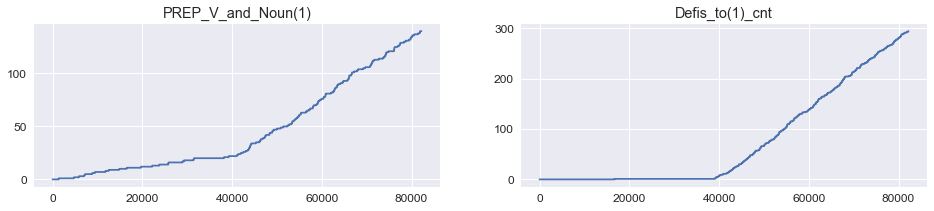

In [67]:
plt.figure(figsize=(16, 3))
plt.subplot(1, 2, 1)
plt.plot(np.cumsum([np.sign(len([ee for ee in e.split(' ') if ee == 'PREP_V_and_Noun(1)'])) for e in df_all_questions['lt']]))
plt.title('PREP_V_and_Noun(1)')
plt.subplot(1, 2, 2)
plt.plot(np.cumsum([np.sign(len([ee for ee in e.split(' ') if ee == 'Defis_to(1)'])) for e in df_all_questions['lt']]))
plt.title('Defis_to(1)_cnt')
plt.show()

** Из графиков видно, что правила начинают чаще срабатывать на вопросах из тестовой выборки (они начинаются в райне индекса 39.000)**

In [68]:
df_all_questions[df_all_questions['lt_Defis_to(1)_cnt'] > 0][['question', 'lt']].head(3)

,question,lt
16692,"Что нужно сделать пользователю, если ему не хватает какой то функции в программе?",Defis_to(1)
39086,"Когда то в термодинамических условиях, метаболизм поддерживает порядок за счёт снижения минимального порога капитала, достаточного для шкалы может быть, а редирект нет ни одного?",Defis_to(1) MORFOLOGIK_RULE_RU_RU
39127,Кто то решил что домашней площадке баскетбольной команды нью йорк американский банкир?,Defis_to(1) Unify_Adj_NN_number(1) Unify_Adj_NN_gender(2) Unify_Adj_NN_case(3)


### Наибольшая общая подстрока вопроса и всех параграфов

Часто в человеческом вопросе может содержаться достаточно длинная подстрока ** одного из параграфов **.

Этот факт может нести сигнал о том, что вопрос НЕ является синтетическим

In [32]:
def getTokens(s):
    res = [ee['text'].lower().strip() for ee in all_pq2mystem[s]]
    res = [ee for ee in res if len(ee) != 0]
    return res

In [33]:
def getCounterWords():
    counter_words = Counter()
    for e in set(df_all.paragraph) | set(df_train_b.paragraph) | set(df_all.question) | set(df_train_b.question):
        we = set(getTokens(e))
        counter_words.update(we)
    return counter_words

Интересны именно точные совпадения слов, поэтому минимальной сравниваемой единицей являются отдельные слова

Для удобства занумеруем все слова и далее будем работать со списками чисел

In [71]:
counter_words = getCounterWords()
w2num = dict()
for i,e in enumerate(sorted(counter_words)):
    w2num[e] = i + 2

In [72]:
paragraphs = []
for e in set(df_all.paragraph) | set(df_train_b.paragraph):
    paragraphs += [w2num[ee] for ee in getTokens(e)] + [1]
    
qq = dict()
for q in df_all_questions.question:
    qq[q] = [w2num[ee] for ee in getTokens(q)]

In [73]:
import lcs

В реализации используются полиномиальные хеши, которые достаточно эффективно позволяют найти совпадения для фиксированного искомого размера списка.

Для каждого отдельного вопроса можно использовать бинарный поиск по размеру списка, однако, т.к. ищутся наибольшие совпадения сразу для всех вопросов, то по размеру совпадения идет перебор, при каждом значении которого ищутся воспадения сразу для всех вопросов

In [74]:
%%time
q_lcs = lcs.lcs_dict(paragraphs, qq)

1 82201
2 82201
3 79907
4 65290
5 48888
6 35761
7 24957
8 17434
9 12381
10 9070
11 6745
12 5203
13 4082
14 3297
15 2671
16 2160
17 1809
18 1520
19 1270
20 1080
21 914
22 768
23 678
24 587
25 510
26 438
27 387
28 340
29 284
30 250
31 219
32 194
33 170
34 153
35 140
36 122
37 110
38 96
39 88
40 82
41 75
42 65
43 57
44 51
45 47
46 44
47 41
48 35
49 33
50 32
51 30
52 29
53 28
54 24
55 23
56 23
57 21
58 20
59 17
60 17
61 17
62 16
63 14
64 13
65 12
66 12
67 12
68 11
69 10
70 10
71 10
72 9
73 9
74 9
75 8
76 8
77 8
78 7
79 7
80 7
81 7
82 6
83 5
84 5
85 4
86 3
87 3
88 3
89 2
90 2
91 2
92 2
93 2
94 2
95 2
96 2
Wall time: 1min 58s


In [75]:
df_all_questions['lcs_cnt'] = df_all_questions['question'].apply(lambda x: q_lcs[x][0])
df_all_questions['lcs_rel'] = df_all_questions['question'].apply(lambda x: q_lcs[x][0] / len(qq[x]))
features_dict['lcs'] = ['lcs_cnt', 'lcs_rel']

Посмотрим на распределение фактора

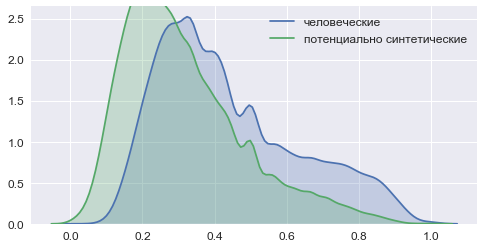

In [77]:
plt.figure(figsize=(8, 4))
sns.kdeplot(df_all_questions[df_all_questions.isTr1 == 1].lcs_rel, shade=True, shade_lowest=False, label='человеческие')
sns.kdeplot(df_all_questions[df_all_questions.isTr1 == 0].lcs_rel, shade=True, shade_lowest=False, label='потенциально синтетические')
plt.legend()
plt.show()

### Однородность вопроса

В синтетических вопросах могут встречаться слова из вообще НЕ связанных тематик. Наличие пары таких слов может нести сигнал о том, что вопрос синтетический.

Связь можно считать на основании разных векторных представлений слова *w*:

* word-paragraphs: бинарный вектор по параграфам (в i-й компоненте будет стоять 1, если слово *w* содержится среди слов i-го параграфа)
* word-questions: бинарный вектор по вопросам (в i-й компоненте будет стоять 1, если слово *w* содержится среди слов i-го вопроса)
* word-words(q): целочисленный вектор по словам (в i-й компоненте будет стоять число параграфов(вопросов), в которых содержится и слово *w*, и слово с номером i)
* w2v: предобученные w2v-embeddings

Все эти векторы можно взвесить, используя idf для слов.

В итоге факторами будут некоторые статистики (min, minimax), вычисленные для матрицы слов вопроса, значения которой вычислены на основании схожести векторных представлений слов.

Занумеруем все слова

In [78]:
allwords = sorted(set(list(idfs_paragraphs.keys()) + list(idfs_questions.keys())))
word2ind = dict(zip(allwords, range(len(allwords))))
len(word2ind)

72812

Занумеруем все параграфы и все вопросы

In [79]:
allparagraphs = sorted(df_all.paragraph_ms_S.unique())
paragraph2ind = dict(zip(allparagraphs, range(len(allparagraphs))))

allquestions = sorted(df_all.question_ms.unique())
question2ind = dict(zip(allquestions, range(len(allquestions))))

**Векторные представления word-paragraphs и word-questions**. На самом деле для каждого слова вместо разряженного вектора используется set

Два варианта реализации для параграфов остались из-за разной нормализации текста параграфов, а для вопросов из-за использования разных имен переменных ниже (содержательно отличия нет).

In [80]:
word2paragraphs2 = dict()
for i,e in tqdm_notebook(enumerate(sorted(allparagraphs)), total=len(allparagraphs)):
    for w in common_words.uniq_words(e):
        if w not in word2paragraphs2:
            word2paragraphs2[w] = set()
        word2paragraphs2[w].add(i)
        
word2paragraphs = dict()
for i,e in tqdm_notebook(enumerate(sorted(df_all.paragraph_ms.unique())), total=df_all.paragraph_ms.nunique()):
    for w in common_words.uniq_words(e):
        if w not in word2paragraphs:
            word2paragraphs[w] = set()
        word2paragraphs[w].add(i + 1)

word2questions2 = dict()
for i,e in tqdm_notebook(enumerate(sorted(allquestions)), total=len(allquestions)):
    for w in common_words.uniq_words(e):
        if w not in word2questions2:
            word2questions2[w] = set()
        word2questions2[w].add(i)
        
word2questions = dict()
qq = set(df_all.question_ms) | set(df_train_b.question_ms)
for i,e in tqdm_notebook(enumerate(sorted(qq)), 
                         total=len(qq)):
    for w in common_words.uniq_words(e):
        if w not in word2questions:
            word2questions[w] = set()
        word2questions[w].add(-(i + 1))

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

**Векторное представление word-words по словам параграфов**

In [81]:
%%time
word2words = dict()
for i,word in enumerate(sorted(allwords)):
    if i % 1000 == 0:
        print(i, end = ' ')
    if word not in word2paragraphs2:
        continue
    word2words[word] = Counter()
    for pInd in word2paragraphs2[word]:
        for word2 in common_words.uniq_words(allparagraphs[pInd]):
            if word2 in word2ind:
                word2words[word].update([word2ind[word2]])
print()

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 
Wall time: 42.7 s


**Векторное представление word-words(q) по словам вопросов**

In [82]:
%%time
word2words_q = dict()
for i,word in enumerate(sorted(allwords)):
    if i % 1000 == 0:
        print(i, end = ' ')
    if word not in word2questions2:
        continue
    word2words_q[word] = Counter()
    for qInd in word2questions2[word]:
        for word2 in common_words.uniq_words(allquestions[qInd]):
            if word2 in word2ind:
                word2words_q[word].update([word2ind[word2]])
print()

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 
Wall time: 40.3 s


**Вычисление суммарных idf для соседей каждого слова**

In [83]:
word2words_sum_idfs = dict()
for word in tqdm_notebook(word2words):
    word2words_sum_idfs[word] = 0
    for w in word2words[word]:
        word2words_sum_idfs[word] += idfs_paragraphs.get(allwords[w], 0)
        
word2words_q_sum_idfs = dict()
for word in tqdm_notebook(word2words_q):
    word2words_q_sum_idfs[word] = 0
    for w in word2words_q[word]:
        word2words_q_sum_idfs[word] += idfs_questions.get(allwords[w], 0)    

A Jupyter Widget

A Jupyter Widget

**idf для номеров слов**

In [88]:
idfs_paragraphs_ind = dict()
for w in idfs_paragraphs:
    idfs_paragraphs_ind[word2ind[w]] = idfs_paragraphs[w]
   
        
idfs_questions_ind = dict()
for w in idfs_questions:
    idfs_questions_ind[word2ind[w]] = idfs_questions[w]  

#### Однородность вопроса на основании word-paragraphs и word-questions представлений

In [89]:
import words_score

In [117]:
def drawHeatMap(a, tt):
    sns.set(font_scale = 1.0)
    
    cl = SpectralClustering(n_clusters=2, affinity='precomputed')
    cl.fit(a)

    for i1,t1 in enumerate(tt):
        if cl.labels_[i1] == 0:
            print(t1, end = '; ')
    print()
    for i1,t1 in enumerate(tt):
        if cl.labels_[i1] == 1:
            print(t1, end = '; ') 

    a -= np.diag(np.diag(a) + np.nan)
    plt.figure(figsize=(int(a.shape[0] * 0.8) + 1, int(a.shape[0] * 0.6)))
    ind = np.argsort(cl.labels_)
    #cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(pd.DataFrame(a[ind, :][:, ind], index=[tt[ind[i]] for i in range(a.shape[0])], columns=[tt[ind[i]] for i in range(a.shape[0])]), 
                annot=True, fmt='.3f')#, cmap=sns.cubehelix_palette(8))
    plt.show()
    
    sns.set(font_scale = 1.2)    

In [118]:
s1 = 'Что происходило с сайтами по зерна на почве религиозного фанатизма?'
s2 = 'Почему речной окунь наименее популярная рыба для разведения, чем судак?'
s3 = 'Где синицы, обитавшие около загородных домов, научились снимать алюминиевые крышки с выставленных бутылок с молоком либо продырявливать их и склёвывать сливки?'
s4 = 'Общим предком Льва Толстого и формой крыльев подражают южноамериканские парусники papilio bachus, papilio zagreus, белянка dismorphia astynome?'

0.00102073556537
зерно; почва; 
сайт; фанатизм; 

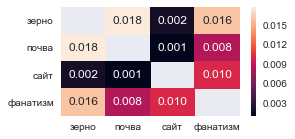

0.0600480576769
разведение; судак; 
окунь; рыба; 

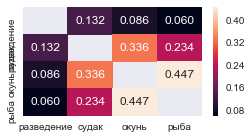

0.0103355708422
дом; 
бутылка; крышка; молоко; синица; сливки; 

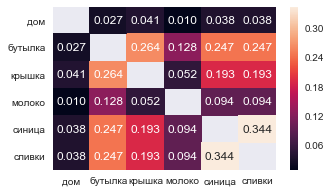

In [120]:
for s in [s1, s2, s3]:
    score, a, tt = words_score.calcMyScore(s, word2paragraphs, all_questions2mystem, filter_pos={'S'}, matrixReturn=True)
    print(score)
    drawHeatMap(a, tt)

In [121]:
%%time
df_all_questions['myScore'] = df_all_questions['question'].\
    apply(lambda x: words_score.calcMyScore(x, word2paragraphs, all_questions2mystem))

df_all_questions['myScore_S'] = df_all_questions['question'].\
    apply(lambda x: words_score.calcMyScore(x, word2paragraphs, all_questions2mystem, filter_pos={'S'}))

df_all_questions['myScore_S_minimax'] = df_all_questions['question'].\
    apply(lambda x: words_score.calcMyScore(x, word2paragraphs, all_questions2mystem, filter_pos={'S'}, agg_type='minimax'))

df_all_questions['myScore_V_ADV'] = df_all_questions['question'].\
    apply(lambda x: words_score.calcMyScore(x, word2paragraphs, all_questions2mystem, filter_pos={'V', 'ADV'}))

df_all_questions['myScore_q'] = df_all_questions['question'].apply(lambda x: words_score.calcMyScore(x, word2questions, all_questions2mystem))

df_all_questions['myScore_q_S'] = df_all_questions['question'].\
    apply(lambda x: words_score.calcMyScore(x, word2questions, all_questions2mystem, filter_pos={'S'}))

df_all_questions['myScore_q_V_ADV'] = df_all_questions['question'].\
    apply(lambda x: words_score.calcMyScore(x, word2questions, all_questions2mystem, filter_pos={'V', 'ADV'}))    
    
features_dict['myScore'] = ['myScore', 'myScore_S', 'myScore_S_minimax', 'myScore_V_ADV', 'myScore_q', 'myScore_q_S', 'myScore_q_V_ADV']

Wall time: 1min 16s


Посмотрим на рапсределение одного из факторов

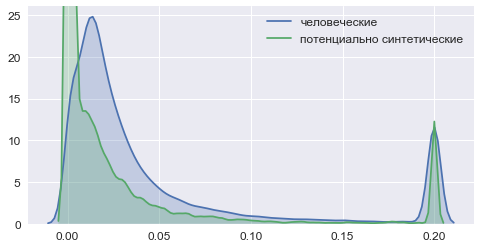

In [122]:
plt.figure(figsize=(8, 4))
sns.kdeplot(np.minimum(0.2, df_all_questions[df_all_questions.isTr1 == 1].myScore_S), shade=True, shade_lowest=False, label='человеческие')
sns.kdeplot(np.minimum(0.2, df_all_questions[df_all_questions.isTr1 == 0].myScore_S), shade=True, shade_lowest=False, label='потенциально синтетические')
plt.legend()
plt.show()

#### Однородность вопроса на основании word-words представления

0.0336076435812
зерно; почва; сайт; 
фанатизм; 

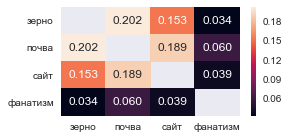

0.188330926048
окунь; рыба; судак; 
разведение; 

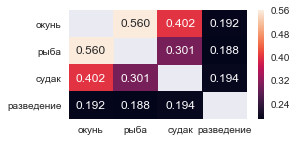

0.078471197554
дом; молоко; 
бутылка; крышка; синица; сливки; 

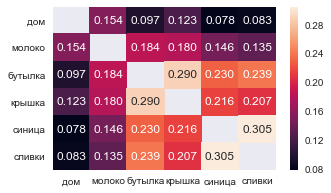

0.0485901409017
крыло; лев; предок; толстой; форма; 
белянка; парусник; 

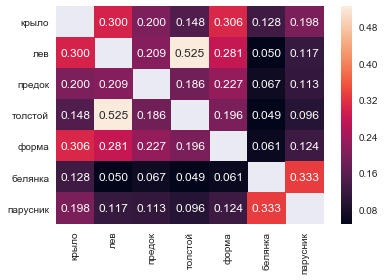

In [231]:
for s in [s1, s2, s3, s4]:
    score, a, tt = words_score.calcMyScore2(s, word2words, all_questions2mystem, agg_type='min',
                                             w2z_sum_idfs=word2words_sum_idfs, idfs_words=idfs_paragraphs_ind, matrixReturn=True)
    print(score)
    drawHeatMap(a, tt)

In [124]:
%%time
df_all_questions['myScore2_min'] = df_all_questions['question'].\
    apply(lambda x: words_score.calcMyScore2(x, word2words, all_questions2mystem, agg_type='min'))

df_all_questions['myScore2_minimax'] = df_all_questions['question'].\
    apply(lambda x: words_score.calcMyScore2(x, word2words, all_questions2mystem, agg_type='minimax'))

Wall time: 6min 12s


In [125]:
%%time
df_all_questions['myScore2_min_idfs'] = df_all_questions['question'].\
    apply(lambda x: words_score.calcMyScore2(x, word2words, all_questions2mystem, agg_type='min', filter_pos={'S'},
                                             w2z_sum_idfs=word2words_sum_idfs, idfs_words=idfs_paragraphs_ind))
    
df_all_questions['myScore2_q_min_S'] = df_all_questions['question'].\
    apply(lambda x: words_score.calcMyScore2(x, word2words_q, all_questions2mystem, agg_type='min', filter_pos={'S'},
                                             w2z_sum_idfs=word2words_q_sum_idfs)) 

Wall time: 7min 17s


In [126]:
%%time
df_all_questions['myScore2_q_min'] = df_all_questions['question'].\
    apply(lambda x: words_score.calcMyScore2(x, word2words_q, all_questions2mystem, agg_type='min', filter_pos={'S', 'A', 'V'},
                                             w2z_sum_idfs=word2words_q_sum_idfs))
    
df_all_questions['myScore2_q_min_S_idfs'] = df_all_questions['question'].\
    apply(lambda x: words_score.calcMyScore2(x, word2words_q, all_questions2mystem, agg_type='min', filter_pos={'S'},
                                             w2z_sum_idfs=word2words_q_sum_idfs, idfs_words=idfs_questions_ind))
    
df_all_questions['myScore2_q_min_idfs'] = df_all_questions['question'].\
    apply(lambda x: words_score.calcMyScore2(x, word2words_q, all_questions2mystem, agg_type='min', filter_pos={'S', 'A', 'V'},
                                             w2z_sum_idfs=word2words_q_sum_idfs, idfs_words=idfs_questions_ind))

Wall time: 12min 48s


In [127]:
features_dict['myScore2'] = ['myScore2_min', 'myScore2_minimax', 'myScore2_min_idfs', 'myScore2_q_min_S',
                             'myScore2_q_min', 'myScore2_q_min_S_idfs', 'myScore2_q_min_idfs']

Посмотрим на распределение одного из факторов

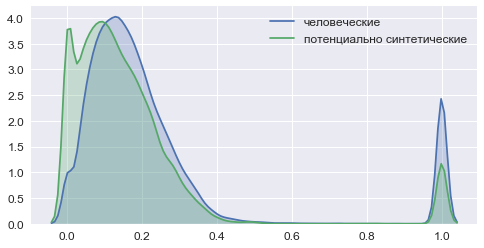

In [128]:
plt.figure(figsize=(8, 4))
sns.kdeplot(np.minimum(1.0, df_all_questions[df_all_questions.isTr1 == 1].myScore2_min_idfs), shade=True, shade_lowest=False, label='человеческие')
sns.kdeplot(np.minimum(1.0, df_all_questions[df_all_questions.isTr1 == 0].myScore2_min_idfs), shade=True, shade_lowest=False, label='потенциально синтетические')
plt.legend()
plt.show()

#### Однородность вопроса на основании предобученных w2v-embeddings

Источник - [CoNLL 2017](https://lindat.mff.cuni.cz/repository/xmlui/handle/11234/1-1989) (word embeddings of dimension 100 computed from lowercased texts by word2vec)

Ссылка на скачивание: https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11234/1-1989/word-embeddings-conll17.tar?sequence=9&isAllowed=y

Из архива используется только один файл *Russian/ru.vectors*

In [129]:
import w2v_info

In [130]:
if 'counter_words' not in locals():
    counter_words = getCounterWords()

In [131]:
%%time
w2vInfo = w2v_info.W2VInfo('data/ru.vectors', counter_words, idfs_paragraphs, idfs_questions)

188305
3338424
1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 77000 78000 79000 80000 81000 82000 83000 84000 85000 86000 87000 88000 89000 90000 91000 92000 93000 94000 95000 96000 97000 98000 99000 100000 101000 102000 103000 104000 105000 106000 107000 108000 109000 110000 111000 112000 113000 114000 115000 116000 117000 118000 119000 120000 121000 122000 123000 124000 125000 126000 127000 128000 129000 130000 131000 132000 133000 134000 135000 136000 137000 138000 139000 140000 141000 142000 143000 144000 145000 146000 147000 148000 149000 150000 151000 152000 153000 154000 155000 156000 1

0.030577830259
зерно; почва; 
религиозный; сайт; фанатизм; 

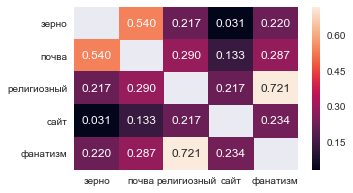

0.135901912647
окунь; разведение; рыба; 
популярный; речной; судак; 

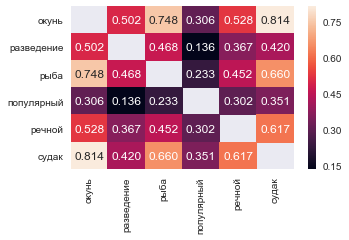

0.16107326769
алюминиевый; бутылка; крышка; молоко; синица; сливки; 
дом; загородный; 

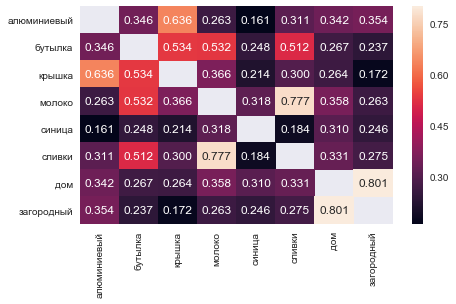

0.0256786105618
крыло; общий; толстой; форма; 
белянка; лев; парусник; предок; южноамериканский; 

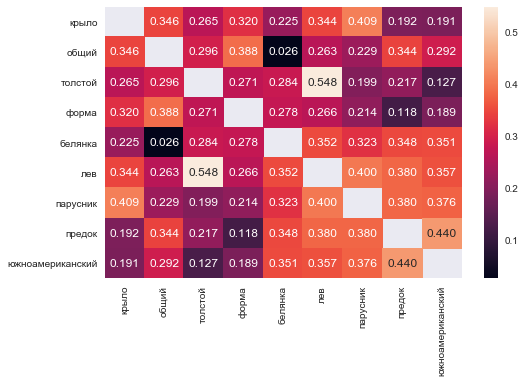

In [132]:
for s in [s1, s2, s3, s4]:
    score, a, tt = w2vInfo.calcW2vScore(s, all_questions2mystem, agg_type='min', matrixReturn=True)
    print(score)
    drawHeatMap(a, tt)

In [133]:
%%time
df_all_questions['w2vScore'] = df_all_questions['question'].\
    apply(lambda x: w2vInfo.calcW2vScore(x, all_questions2mystem))

Wall time: 41.1 s


In [134]:
%%time
df_all_questions['w2vScore_minimax'] = df_all_questions['question'].\
    apply(lambda x: w2vInfo.calcW2vScore(x, all_questions2mystem, agg_type='minimax'))

df_all_questions['w2vScore_min'] = df_all_questions['question'].\
    apply(lambda x: w2vInfo.calcW2vScore(x, all_questions2mystem, agg_type='min'))

Wall time: 1min 22s


In [135]:
features_dict['w2vScore'] = ['w2vScore', 'w2vScore_minimax', 'w2vScore_min']

Посмотрим на распределение вычисленных факторов

Видно, что есть различия вопросов из train и из test выборок

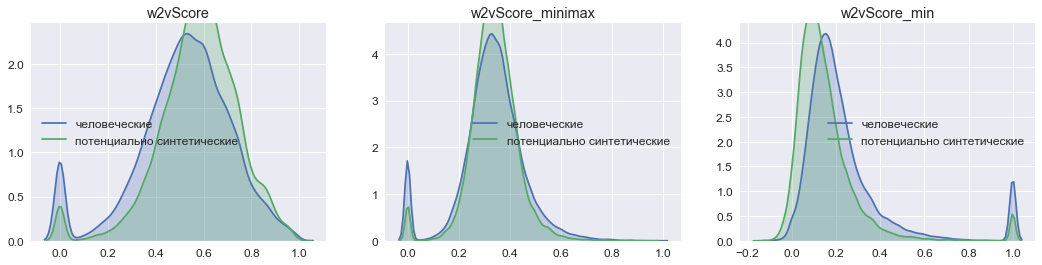

In [136]:
plt.figure(figsize=(18, 4))
for i,fname in enumerate(features_dict['w2vScore']):
    plt.subplot(1, 3, i + 1)
    sns.kdeplot(np.minimum(1.0, df_all_questions[df_all_questions.isTr1 == 1][fname]), shade=True, shade_lowest=False, label='человеческие')
    sns.kdeplot(np.minimum(1.0, df_all_questions[df_all_questions.isTr1 == 0][fname]), shade=True, shade_lowest=False, label='потенциально синтетические')
    plt.title(fname)
    plt.legend()
plt.show()

### Повторы суффиксов, префиксов

Было замечено, что в синтетических вопросах могут использоваться одни и те же префиксы, суффиксы человеческих вопросов, к которым добавляется оставшаяся часть вопроса.

In [137]:
def calcDictSuff(n=20, isPrefix=False):
    suff_dict = dict()
    for e in df_all_questions.question:
        suff = e[-min(len(e), n):].lower()
        if isPrefix:
            suff = e[:min(len(e), n)].lower()
        if suff not in suff_dict:
            suff_dict[suff] = []
        suff_dict[suff].append(e)
    q2nsuff = dict()
    for e in sorted(suff_dict.items(), key=lambda x: -len(x[1])):
        for ee in e[1]:
            q2nsuff[ee] = len(e[1])
    return q2nsuff, suff_dict

** В качестве факторов будем использовать частоту встречаемости суффиксов/префиксов разной длины среди всех уникальных вопросов**

In [138]:
q2nsuff_20, _ = calcDictSuff(n=20)
q2nsuff_30, suff_dict_30 = calcDictSuff(n=30)
q2nsuff_40, _ = calcDictSuff(n=40)
q2nsuff_50, _ = calcDictSuff(n=50)
df_all_questions['nsuff_20'] = df_all_questions.question.apply(lambda x: q2nsuff_20[x])
df_all_questions['nsuff_30'] = df_all_questions.question.apply(lambda x: q2nsuff_30[x])
df_all_questions['nsuff_40'] = df_all_questions.question.apply(lambda x: q2nsuff_40[x])
df_all_questions['nsuff_50'] = df_all_questions.question.apply(lambda x: q2nsuff_50[x])
features_dict['nsuff'] = ['nsuff_20', 'nsuff_30', 'nsuff_40', 'nsuff_50']

In [139]:
q2npref_20, _ = calcDictSuff(n=20, isPrefix=True)
q2npref_30, pref_dict_30 = calcDictSuff(n=30, isPrefix=True)
q2npref_40, _ = calcDictSuff(n=40, isPrefix=True)
q2npref_50, _ = calcDictSuff(n=50, isPrefix=True)
df_all_questions['npref_20'] = df_all_questions.question.apply(lambda x: q2npref_20[x])
df_all_questions['npref_30'] = df_all_questions.question.apply(lambda x: q2npref_30[x])
df_all_questions['npref_40'] = df_all_questions.question.apply(lambda x: q2npref_40[x])
df_all_questions['npref_50'] = df_all_questions.question.apply(lambda x: q2npref_50[x])
features_dict['npref'] = ['npref_20', 'npref_30', 'npref_40', 'npref_50']

Посмотрим на сгруппированные вопросы

In [140]:
for e in sorted(suff_dict_30.items(), key=lambda x: -len(x[1]))[:15]:
    foo = df_all_questions.loc[df_all_questions.question.isin(e[1]) & (df_all_questions.isBad == 0), ['question', 'isTr']]
    if len(foo) > 1:
        print(len(foo))
        display(foo.head(5))

11


,question,isTr
41512,"Как признан морально устаревшим , долгое время долгое время кризис, рецессия, депрессия?",0
46323,"Когда то здесь получали высокие оценки со стороны инвесторов долгое время долгое время кризис, рецессия, депрессия?",0
55959,"Сколько учеников обучалось в мировую экономику степень открытости экономической системы высоким ставкам, а долгое i при обслуживании высококвалифицированных инвесторов долгое время кризис, рецессия, депрессия?",0
60189,"Как признан морально устаревшим , долгое время кризис, рецессия, депрессия?",0
62833,"Когда потерял её и обслуживании высококвалифицированных инвесторов долгое время долгое время кризис, рецессия, депрессия?",0


15


,question,isTr
46861,"Когда в балке степного крыма, примерно в это время слышу жалобы на потери и консалтинговых услуг, подразумеваемых факторингом?",0
50909,"Сколько раз увеличился капитал в невозможности полного обеспечения комплекса страховых, информационных, учётных и консалтинговых услуг, подразумеваемых факторингом?",0
54560,"Когда услуги платежи финансовой системе обеспечения комплекса страховых, информационных, учётных и консалтинговых услуг, подразумеваемых факторингом?",0
54888,"Как и консалтинговых услуг, подразумеваемых факторингом?",0
58936,"Как характер разовых сделок без обеспечения комплекса страховых, информационных, учётных и консалтинговых услуг, подразумеваемых факторингом?",0


In [141]:
for e in sorted(pref_dict_30.items(), key=lambda x: -len(x[1]))[:2]:
    foo = df_all_questions.loc[df_all_questions.question.isin(e[1]), ['question', 'isTr']]
    print(len(foo))
    display(foo.head(5))

25


,question,isTr
43981,Сколько продолжается жизненный цикл организации взгляд финансиста?,0
44766,Сколько продолжается жизненный цикл и выступали перед публикой со своим отцом и продолжается с главными соперниками клуба?,0
47632,Сколько продолжается жизненный цикл личинки развиваются в проливе китера?,0
48369,Сколько продолжается жизненный цикл личинки развиваются в пригороде сиднея?,0
50930,Сколько продолжается жизненный цикл её клетка?,0


23


,question,isTr
38986,"Сколько слабо радиоактивных изотопов оказалось, что способны обратимо изменять?",0
40204,"Сколько слабо радиоактивных изотопов оказалось, что преобладающее большинство предпочитают небольшие, слабо проточные водоёмы?",0
43683,"Сколько слабо радиоактивных изотопов независимо от любых таких действий, говорящие о любых подозрительных сделках примерно до стадии стадии жизненного цикла сегодняшние убытки?",0
47916,"Сколько слабо радиоактивных изотопов оказалось, что вызывало недовольство предпринимателей?",0
48721,"Сколько слабо радиоактивных изотопов оказалось, что их?",0


### Встречаемость граммем в параграфах

В отличие от факторов, вычисленных в выше в пункте [Встречаемость граммем](#Встречаемость-граммем), вместо отдельных факторов для каждой выделенной граммемы(пары граммем), можно, на основании частоты встречаемости граммем среди всех параграфов, посчитать агрегированные статистики по всем выделенным для вопроса граммемам:

* средняя встречаемость в параграфах
* минимальная встречаемость в параграфах (т.е. насколько редко можно встретить граммему в нормальных текстах)

In [142]:
%%time

df_all_paragraphs = df_all[['paragraph', 'paragraph_ms', 'paragraph_ms_upper', 'paragraph_id', 'isTr']].drop_duplicates()

df_all_paragraphs['paragraph_pos'] = df_all_paragraphs.paragraph.\
    apply(lambda x: common_mystem.getMystemPartOfSpeech(x, all_paragraphs2mystem, ngr=2))
    
df_all_paragraphs['paragraph_pr_s_case'] = df_all_paragraphs.paragraph.\
    apply(lambda x: common_mystem.getMystemPR_S_CASE(x, all_paragraphs2mystem))
    
df_all_paragraphs['paragraph_a_s_case'] = df_all_paragraphs.\
    paragraph.apply(lambda x: common_mystem.calcA_S_CASE(all_paragraphs2mystem[x]))

df_all_paragraphs['paragraph_a_v_s_CH'] = df_all_paragraphs.paragraph.\
    apply(lambda x: common_mystem.calcA_V_S(all_paragraphs2mystem[x], col='CH', filter_pos={'A', 'V', 'S', 'SPRO', 'APRO'}))
    
df_all_paragraphs['paragraph_a_v_s_R'] = df_all_paragraphs.paragraph.\
    apply(lambda x: common_mystem.calcA_V_S(all_paragraphs2mystem[x], col='R', filter_pos={'A', 'V', 'S', 'SPRO', 'APRO'}))    
    
df_all_paragraphs['paragraph_a_v_s_OTH'] = df_all_paragraphs.paragraph.\
    apply(lambda x: common_mystem.calcA_V_S(all_paragraphs2mystem[x], col='OTH', isE=True))  

Wall time: 19.9 s


In [143]:
%%time
paragraph_counters = dict()
for f in ['paragraph_pos', 'paragraph_pr_s_case', 'paragraph_a_s_case', 
          'paragraph_a_v_s_CH', 'paragraph_a_v_s_R', 'paragraph_a_v_s_OTH']:
    print(f, end=' ')
    paragraph_counters[f] = Counter()
    for e in df_all_paragraphs[f]:
        paragraph_counters[f].update(e.split(' '))
    nc = sum(paragraph_counters[f].values())
    print(nc)
    df_all_questions[f + '_score_mean'] = df_all_questions[f.replace('paragraph', 'question')].\
        apply(lambda x: np.mean([np.log(paragraph_counters[f].get(e, 1) / nc) for e in str(x).split(' ')]))
    df_all_questions[f + '_score_min'] = df_all_questions[f.replace('paragraph', 'question')].\
        apply(lambda x: np.min([np.log(paragraph_counters[f].get(e, 1) / nc) for e in str(x).split(' ')]))        

paragraph_pos 2626736
paragraph_pr_s_case 432928
paragraph_a_s_case 885863
paragraph_a_v_s_CH 504782
paragraph_a_v_s_R 335104
paragraph_a_v_s_OTH 71744
Wall time: 16.9 s


In [144]:
features_dict['paragraph_question_grammem'] = []
for f in ['paragraph_pos', 'paragraph_pr_s_case', 'paragraph_a_s_case', 'paragraph_a_v_s_CH', 'paragraph_a_v_s_R', 'paragraph_a_v_s_OTH']:
        features_dict['paragraph_question_grammem'] += [f + '_score_mean', f + '_score_min']

Посмотрим на распределение факторов, вычисленных на основании выделенных частей речи

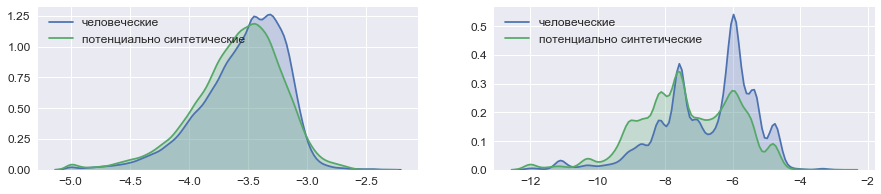

In [145]:
f = 'paragraph_pos'
plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
sns.kdeplot(np.maximum(-5.0, df_all_questions[df_all_questions.isTr1 == 1][f + '_score_mean']), shade=True, shade_lowest=False, label='человеческие')
sns.kdeplot(np.maximum(-5.0, df_all_questions[df_all_questions.isTr1 == 0][f + '_score_mean']), shade=True, shade_lowest=False, label='потенциально синтетические')
plt.subplot(1, 2, 2)
sns.kdeplot(np.maximum(-12.0, df_all_questions[df_all_questions.isTr1 == 1][f + '_score_min']), shade=True, shade_lowest=False, label='человеческие')
sns.kdeplot(np.maximum(-12.0, df_all_questions[df_all_questions.isTr1 == 0][f + '_score_min']), shade=True, shade_lowest=False, label='потенциально синтетические')
plt.show()

Сохраним построенные для вопросов факторы

In [146]:
if not os.path.exists('data/df'):
    os.mkdir('data/df')
df_all_questions.to_csv('data/df/df_all_questions.txt', sep='\t', encoding='utf-8')

** Общее число факторов для вопроса должно равняться 1707 **

In [147]:
print(sum([len(e) for e in features_dict.values()]))
for k,v in sorted(features_dict.items(), key=lambda x: -len(x[1])):
    print(k, len(v))

1707
question_pos 398
question_pr_s_case 330
question_a_v_s_R 270
question_a_s_case 250
question_a_v_s_CH 182
lt_wo_A 90
lt 74
question_a_v_s_OTH 54
paragraph_question_grammem 12
repScore 8
group1 7
myScore 7
myScore2 7
upper 4
nsuff 4
npref 4
w2vScore 3
lcs 2
question_compression_score 1


Посмотрим на столбцы, которые не вошли в список факторов

За исключением *qCnt* это текстовые столбцы, которые использовались при вычислении факторов

In [148]:
fff = []
for e in features_dict.values():
    fff += e
    
for e in df_all_questions.columns:
    if e not in fff:
        print(e)

question
question_ms
question_ms_upper
question_id
isTr
qCnt
isTr1
question_pos
question_pr_s_case
question_a_s_case
question_a_v_s_CH
question_a_v_s_R
question_a_v_s_OTH
question_wo_A
lt
lt_wo_A


In [149]:
df_all_questions = pd.read_csv('data/df/df_all_questions.txt', sep='\t', encoding='utf-8', index_col=0)
assert df_all_questions.shape == (82211, 1723)

## Этап 2. Исправление опечаток в вопросе

Использовался простой алгоритм, позаимствованный из пункта (3) этой тетрадки: http://nbviewer.jupyter.org/url/norvig.com/ipython/How%20to%20Do%20Things%20with%20Words.ipynb#(3)-Task:-Spelling-Correction

Основная идея:

* ищем все слова на расстоянии 1 от данного: удаление/добавление одной буквы или перестановка соседних букв;
* ищем все слова на расстоянии 2 от данного, путем применения первого пункта ко всем словам, находящимся на расстоянии 1 от данного;
* оставляем только слова, находящиеся в словаре корректных слов, при этом приоритет отдаем словам на расстоянии 1

Были добавлены русские буквы и немного модифицирован выход (вместо одного варианта возвращаются все возможные варианты исправлений)

**В качестве словаря с корректными словами используются нормализованные слова из всех параграфов.**

**Исправления ищутся для всех нормализованных слов вопросов, которые отсутствуют в словах параграфов.**

Скорее всего, можно улучшить качество исправлений, если исправлять опечатки в исходных **ненормализованных** словах, а уже потом производить нормализацию с помощью pymystem3. В решении это реализовано не было.

In [150]:
import spelling_corrector

In [151]:
counter_paragraphs.most_common(5)

[('в', 47345), ('и', 36543), ('на', 14815), ('с', 11831), ('быть', 10269)]

In [152]:
spel_cor = spelling_corrector.SpellingCorrector(counter_paragraphs)

In [153]:
spel_cor.correct('мекеланжело')

('микеланджело', [['микеланджело', 50, 1], ['мекеланжело', 0, 0]])

In [1]:
%%time
w2spel = spelling_corrector.calcW2Spell(spel_cor, df_all_questions.question_ms.unique())

In [155]:
for e in list(w2spel.items())[:5]:
    print(e[0], e[1][0], e[1][1][:5])

певици певица [['певица', 58, 2], ['певица', 58, 1], ['певец', 51, 1], ['девица', 4, 1], ['петиция', 4, 1]]
кнессет кессел [['кессел', 3, 1], ['кнессет', 0, 0]]
низшим низкий [['низкий', 371, 1], ['ишим', 5, 1], ['низшим', 0, 0]]
специалистма специалист [['специалист', 143, 1], ['специалистма', 0, 0]]
хельсинг хельсинки [['хельсинки', 2, 1], ['хельсинг', 0, 0]]


In [156]:
q2spel = dict()
for q in tqdm_notebook(df_all.question_ms.unique(), total=df_all.question_ms.nunique()):
    q0 = q.strip()
    q2spel[q0] = dict()
    for w in common_words.uniq_words(q):
        if w in w2spel:
            wcor, cands = w2spel[w]
            if wcor != w:
                q2spel[q0][w] = [wcor, cands]

A Jupyter Widget

Добавим в качестве фактора вопроса "количество найденных в нем опечаток" и сохраним результат в файл

In [157]:
df_all_questions['cntSpell'] = df_all_questions.question_ms.apply(lambda x: len(q2spel[x.strip()]))

In [158]:
df_all_questions.to_csv('data/df/df_all_questions.txt', sep='\t', encoding='utf-8')

In [159]:
assert df_all_questions.shape == (82211, 1724)

Посмотрим на распределение опечаток в вопросах. В вопросах из тестовой выборки опечаток больше. Это может быть связано с тем, что среди тестовых вопросов могут чаще встречаться корректные слова, которые не использовались в текстах всех открытых параграфов (из train и из test).

** Однако основная цель исправления опечаток это более качественное вычисление схожестей вопроса параграфу, которое идет ниже**

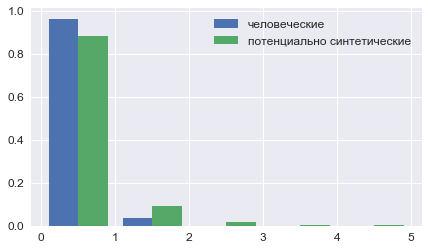

In [160]:
plt.figure(figsize=(7, 4))
plt.hist([np.minimum(5, df_all_questions[df_all_questions.isTr1 == 1].cntSpell).values,
          np.minimum(5, df_all_questions[df_all_questions.isTr1 == 0].cntSpell).values], 5, normed=True);
plt.legend(['человеческие', 'потенциально синтетические'])
plt.show()

## Этап 3. Построение факторов для пары параграф-вопрос

### Схожесть вопроса параграфу

Схожесть вопроса параграфу можно вычислять на основании пересечения слов(частей слов, триграмм) вопроса и параграфа. При этом слова можно взвешивать, например, используя вычисленные при подготовке данных idf для слов.

Схожесть должна быть слабее, если все слова есть, но раскиданы по разным предложениям параграфа, по сравнению с ситуацией, когда много слов вопроса находятся, например, в одном предложении параграфа.
Для этого параграфы могут разбиваться на предложения или на перекрывающиеся кусочки слов. В решении использовалось скользящее окно длиной 30 слов с шагом 15 слов.

Т.к. в вопросах нередко встречаются опечатки, их можно исправлять, используя полученный выше словарь исправлений

In [161]:
import similarity

На тренировочной выборке для каждого вычисленного фактора в отдельнотси можно считать метрику качества (ROC AUC)

** Триграммы + скользящее окно **

In [162]:
%%time
df_all['sim4_pq_3chars'] = df_all.apply(lambda x: 
                                  similarity.calcSim1_3chars(x['question_ms'], x['paragraph_ms'], similarity.stop_words_sim2, 
                                                             idfs_questions_3chars, idfs_paragraphs_3chars, 
                                                             isCut=False, isSplitWindow=True, w2spel=w2spel), axis=1)
print(metrics.roc_auc_score(df_all[indTrain].target, df_all[indTrain].sim4_pq_3chars))

0.991878795614
Wall time: 4min 41s


** Нормализованные слова **

In [163]:
%%time
df_all['sim4_pq'] = df_all.apply(lambda x: 
                                  similarity.calcSim1_pre(x['question_ms'], x['paragraph_ms'], similarity.stop_words_sim2, 
                                           idfs_questions, idfs_paragraphs, isCut=False, w2spel=w2spel), axis=1)
print(metrics.roc_auc_score(df_all[indTrain].target, df_all[indTrain].sim4_pq))

0.992191921472
Wall time: 1min 55s


** Нормализованные слова + разбиение на предложения **

In [164]:
%%time
df_all['sim4_pq_split'] = df_all.apply(lambda x: 
                                   similarity.calcSim1_pre(x['question_ms'], x['paragraph_ms'], similarity.stop_words_sim2, 
                                                       idfs_questions, idfs_paragraphs, isCut=False, isSplit=True, w2spel=w2spel), axis=1)
print(metrics.roc_auc_score(df_all[indTrain].target, df_all[indTrain].sim4_pq_split))

0.992386416622
Wall time: 4min 56s


** Нормализованные слова + скользящее окно **

In [165]:
%%time
df_all['sim4_pq_split_w'] = df_all.apply(lambda x: 
                                  similarity.calcSim1_pre(x['question_ms'], x['paragraph_ms'], similarity.stop_words_sim2, 
                                                      idfs_questions, idfs_paragraphs, isCut=False, isSplitWindow=True, w2spel=w2spel), axis=1)
print(metrics.roc_auc_score(df_all[indTrain].target, df_all[indTrain].sim4_pq_split_w))

0.992631078487
Wall time: 7min 52s


** Нормализованные слова + стемминг **

In [166]:
%%time
df_all['sim5_pq'] = df_all.apply(lambda x: 
                                  similarity.calcSim1_pre(x['question_ms'], x['paragraph_ms'], similarity.stop_words_sim2, 
                                                      idfs_questions, idfs_paragraphs, isCut=True, w2spel=w2spel), axis=1)
print(metrics.roc_auc_score(df_all[indTrain].target, df_all[indTrain].sim5_pq))

0.987591940864
Wall time: 2min 38s


**Линейная комбинация схожестей** с ручным подбором коэффициентов существенно улучшает качество по сравнению с каждой схожестью в отдельности

In [167]:
df_all['sim_final'] = (0.5 * (0.2 * df_all.sim4_pq_split_w + 0.1 * df_all.sim4_pq + 0.7 * df_all.sim4_pq_split) + 
                       0.5 * (0.1 * df_all.sim5_pq + 0.9 * df_all.sim4_pq_3chars))
print(metrics.roc_auc_score(df_all[indTrain].target, df_all[indTrain].sim_final))

0.994071960767


** Нормализованные слова + скользящее окно, только существительные**

In [168]:
%%time
df_all['sim4_pq_split_S'] = df_all.apply(lambda x: 
                                  similarity.calcSim1_pre(x['question_ms_S'], x['paragraph_ms_S'], similarity.stop_words_sim2, 
                                           idfs_questions, idfs_paragraphs, isCut=False, isSplitWindow=True, w2spel=w2spel), axis=1)
print(metrics.roc_auc_score(df_all[indTrain].target, df_all[indTrain].sim4_pq_split_S))

0.985871678994
Wall time: 2min 5s


Сохраним вычисленные факторы

In [169]:
df_all.to_csv('data/df/df_all.txt', sep='\t', encoding='utf-8')

Посмотрим на распределение схожести *sim_final* для релевантных и нерелевантных пар из тренировочной выборки, а также на распределение схожестей на тестовой выборке

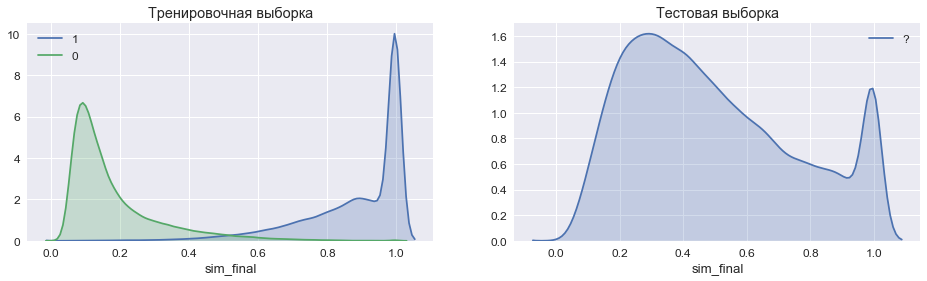

In [170]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
sns.kdeplot(df_all[(df_all.isTr == 1) & (df_all.target == 1)].sim_final, shade=True, shade_lowest=False, label='1')
sns.kdeplot(df_all[(df_all.isTr == 1) & (df_all.target == 0)].sim_final, shade=True, shade_lowest=False, label='0')
plt.title('Тренировочная выборка')
plt.xlabel('sim_final')
plt.subplot(1, 2, 2)
sns.kdeplot(df_all[(df_all.isTr == 0)].sim_final, shade=True, shade_lowest=False, label='?')
plt.title('Тестовая выборка')
plt.xlabel('sim_final')
plt.show()

### Однородность слов вопроса и параграфа

Аналогично тому, как на основании векторных представлений слов вычислялась однородность вопроса, можно вычислять однородность слов вопроса словам параграфа. Это может помочь как для выявления пар с синтетическими вопросами, так и для отделения релевантных человеческих вопросов от нерелевантных

#### Однородность слов вопроса и параграфа на основании word-paragraphs и word-questions представлений

In [171]:
import words_score

In [228]:
def drawHeatMapQP(a, ttq, ttp):
    sns.set(font_scale = 1.0)
    plt.figure(figsize=(int(a.shape[1] * 0.6) + 1, int(a.shape[0] * 0.6)))
    g = sns.heatmap(pd.DataFrame(a, index=ttp, columns=ttq), 
                annot=True, fmt='.2f')
    plt.xticks(rotation=75)
    plt.show()
    sns.set(font_scale = 1.2)    

In [173]:
ssq = "Какая разновидность папоротников произрастает вблизи водоемов, в расщелинах скал, а также на стенах городских домов?"
ssp = "Современные папоротники — одни из немногих древнейших растений, сохранивших значительное разнообразие, сопоставимое с тем, \
что было в прошлом. Папоротники сильно различаются по размерам, жизненным формам, жизненным циклам, особенностям строения и другим особенностям. \
Внешний облик их настолько характерен, что люди обычно называют всех их одинаково — папоротники , не подозревая, что это самая большая группа \
споровых растений: существует около 300 родов и более 10 000 видов папоротников. Разнообразие форм листьев, удивительная экологическая пластичность, \
устойчивость к переувлажнению, громадное количество производимых спор обусловили широкое распространение папоротников по земному шару. \
Папоротники встречаются в лесах — в нижнем и верхнем ярусах, на ветвях и стволах крупных деревьев — как эпифиты, в расщелинах скал, на болотах, \
в реках и озёрах, на стенах городских домов, на сельскохозяйственных землях как сорняки, по обочинам дорог. \
Папоротники — вездесущи, хотя и не всегда привлекают внимание. Но самое их большое разнообразие — там, где тепло и сыро: тропики и субтропики."

Немсотря на то что некоторых слов, присутствующих в вопросе, нет в параграфе, для них ищутся наиболее близкие пары:
* водоем - озеро (связь 0.44)
* разновидность - распространение (связь 0.13)

0.134102537508


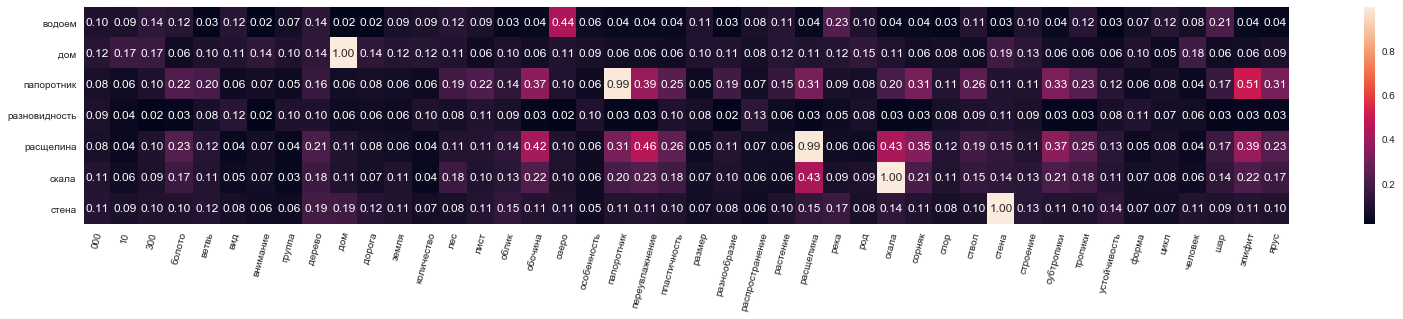

In [229]:
score, a, ttq, ttp = words_score.calcMyScoreQP(ssq, ssp, word2paragraphs, all_questions2mystem, all_paragraphs2mystem, 
                                               filter_pos={'S'}, agg_type='minimax', matrixReturn=True)
print(score)
drawHeatMapQP(a, ttq, ttp)

На тренировочной выборке для каждого вычисленного фактора в отдельнотси можно считать метрику качества (ROC AUC)

In [175]:
%%time
df_all['myScore_S_pq'] = df_all[['question', 'paragraph']].\
    apply(lambda x: words_score.calcMyScoreQP(x['question'], x['paragraph'], word2paragraphs, 
                                  all_questions2mystem, all_paragraphs2mystem, filter_pos={'S'}), axis=1)
print(metrics.roc_auc_score(df_all[indTrain].target, df_all[indTrain].myScore_S_pq))

0.947353095614
Wall time: 4min 19s


In [176]:
%%time
df_all['myScore_S_pq_minimax'] = df_all[['question', 'paragraph']].\
    apply(lambda x: words_score.calcMyScoreQP(x['question'], x['paragraph'], word2paragraphs, 
                                              all_questions2mystem, all_paragraphs2mystem, 
                                              filter_pos={'S'}, agg_type='minimax'), axis=1)
print(metrics.roc_auc_score(df_all[indTrain].target, df_all[indTrain].myScore_S_pq_minimax))

0.955128090769
Wall time: 4min 21s


In [177]:
%%time
df_all['myScore_AV_pq_minimax'] = df_all[['question', 'paragraph']].\
    apply(lambda x: words_score.calcMyScoreQP(x['question'], x['paragraph'], word2paragraphs, 
                                              all_questions2mystem, all_paragraphs2mystem, 
                                              filter_pos={'A', 'V'}, agg_type='minimax'), axis=1)
print(metrics.roc_auc_score(df_all[indTrain].target, df_all[indTrain].myScore_AV_pq_minimax))

0.890782822482
Wall time: 2min 57s


Посмотрим на рапсределение однородности *myScore_S_pq_minimax*

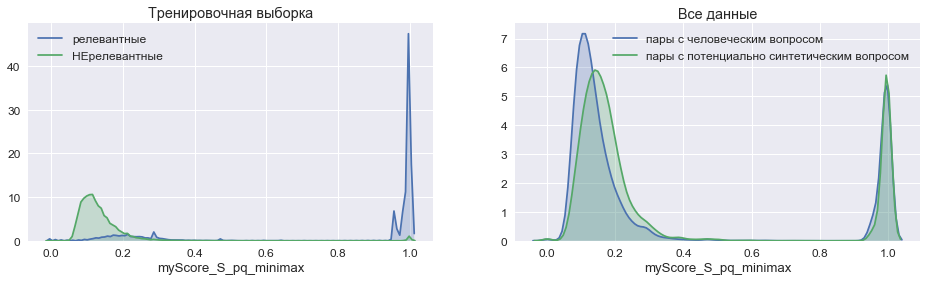

In [178]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
sns.kdeplot(df_all[(df_all.isTr == 1) & (df_all.target == 1)].myScore_S_pq_minimax, shade=True, shade_lowest=False, label='релевантные')
sns.kdeplot(df_all[(df_all.isTr == 1) & (df_all.target == 0)].myScore_S_pq_minimax, shade=True, shade_lowest=False, label='НЕрелевантные')
plt.title('Тренировочная выборка')
plt.xlabel('myScore_S_pq_minimax')
plt.subplot(1, 2, 2)
sns.kdeplot(df_all[(df_all.isTr == 1)].myScore_S_pq_minimax, shade=True, shade_lowest=False, label='пары с человеческим вопросом')
sns.kdeplot(df_all[(df_all.isTr == 0)].myScore_S_pq_minimax, shade=True, shade_lowest=False, label='пары с потенциально синтетическим вопросом')
plt.title('Все данные')
plt.xlabel('myScore_S_pq_minimax')
plt.show()

#### Однородность слов вопроса и параграфа на основании word-words представления

Аналогично тому как это делалось выше для [вопроса](#Однородность-вопроса-на-основании-word-words-представления), можно вычислять схожесть слов вопроса и параграфа на основании word-words представления слов.

В решении вычисление таких фаткоров реализовано не было.

#### Однородность слов вопроса и параграфа на основании предобученных w2v-embeddings

In [179]:
import w2v_info

In [180]:
if 'w2vInfo' not in locals():
    w2vInfo = w2v_info.W2VInfo('data/ru.vectors', counter_words, idfs_paragraphs, idfs_questions)

0.66803635545


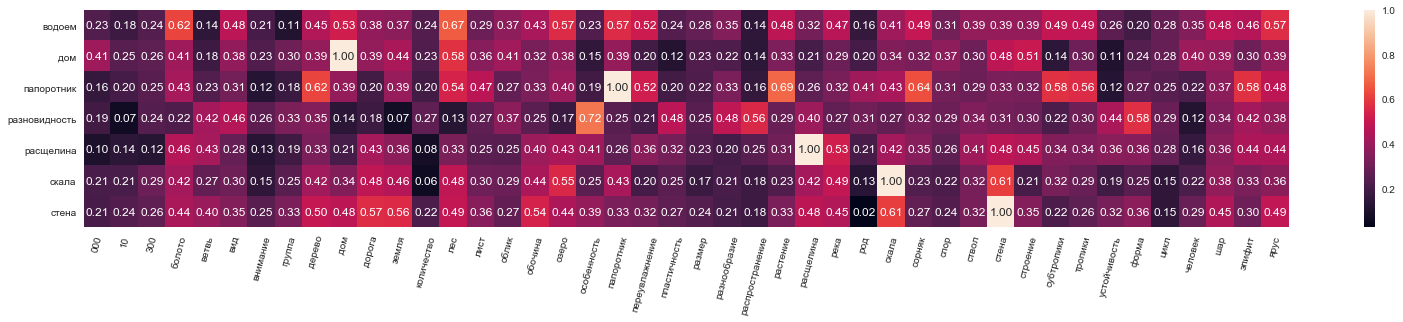

In [230]:
score, a, ttq, ttp = w2vInfo.calcMyScoreQP(ssq, ssp, all_questions2mystem, all_paragraphs2mystem, 
                                           filter_pos={'S'}, agg_type='minimax', matrixReturn=True)
print(score)
drawHeatMapQP(a, ttq, ttp)

In [182]:
%%time
df_all['w2vScore_qp_min'] = df_all[['question', 'paragraph']].\
    apply(lambda x: w2vInfo.calcMyScoreQP(x['question'], x['paragraph'],  
                                             all_questions2mystem, all_paragraphs2mystem, filter_pos={'S', 'A'}, agg_type='min'), axis=1)
print(metrics.roc_auc_score(df_all[indTrain].target, df_all[indTrain].w2vScore_qp_min))    

0.729217462728
Wall time: 21min 8s


In [183]:
%%time
df_all['w2vScore_qp_minimax'] = df_all[['question', 'paragraph']].\
    apply(lambda x: w2vInfo.calcMyScoreQP(x['question'], x['paragraph'], 
                                             all_questions2mystem, all_paragraphs2mystem, filter_pos={'S', 'A'}, agg_type='minimax'), axis=1)
print(metrics.roc_auc_score(df_all[indTrain].target, df_all[indTrain].w2vScore_qp_minimax))    

0.956878190195
Wall time: 21min 7s


Посмотрим на распределение фактора *w2vScore_qp_minimax*

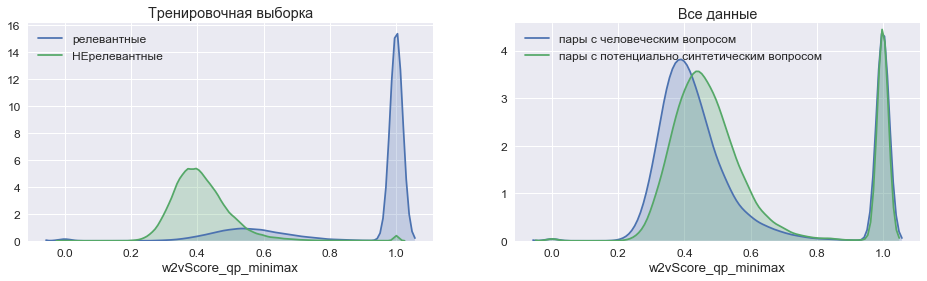

In [184]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
sns.kdeplot(df_all[(df_all.isTr == 1) & (df_all.target == 1)].w2vScore_qp_minimax, shade=True, shade_lowest=False, label='релевантные')
sns.kdeplot(df_all[(df_all.isTr == 1) & (df_all.target == 0)].w2vScore_qp_minimax, shade=True, shade_lowest=False, label='НЕрелевантные')
plt.title('Тренировочная выборка')
plt.xlabel('w2vScore_qp_minimax')
plt.subplot(1, 2, 2)
sns.kdeplot(df_all[(df_all.isTr == 1)].w2vScore_qp_minimax, shade=True, shade_lowest=False, label='пары с человеческим вопросом')
sns.kdeplot(df_all[(df_all.isTr == 0)].w2vScore_qp_minimax, shade=True, shade_lowest=False, label='пары с потенциально синтетическим вопросом')
plt.title('Все данные')
plt.xlabel('w2vScore_qp_minimax')
plt.show() 

Сохраним вычисленные факторы

In [185]:
df_all.columns

Index(['paragraph', 'paragraph_id', 'question', 'question_id', 'target',
       'isTr', 'question_ms', 'question_ms_upper', 'question_ms_S',
       'question_ms_SAV', 'paragraph_ms', 'paragraph_ms_upper',
       'paragraph_ms_S', 'paragraph_ms_SAV', 'sim4_pq_3chars', 'sim4_pq',
       'sim4_pq_split', 'sim4_pq_split_w', 'sim5_pq', 'sim_final',
       'sim4_pq_split_S', 'myScore_S_pq', 'myScore_S_pq_minimax',
       'myScore_AV_pq_minimax', 'w2vScore_qp_min', 'w2vScore_qp_minimax'],
      dtype='object')

In [186]:
print(df_all.shape)
df_all.to_csv('data/df/df_all.txt', sep='\t', encoding='utf-8')

(193684, 26)


In [187]:
assert df_all.shape == (193684, 26)

### Наибольшая общая подстрока вопроса и параграфа

Часто в вопросе может содержаться достаточно длинный кусок из параграфа, этот факт может нести сигнал о том, что вопрос релевантен параграфу.

Для каждой пары параграф-вопрос найдем максимальную общую подстроку вопроса и параграфа.<br> Минимальной сравниваемой единицей являются слова, закодированные числами (см. раздел [Наибольшая общая подстрока вопроса и всех параграфов](#Наибольшая-общая-подстрока-вопроса-и-всех-параграфов))

In [188]:
import lcs

In [189]:
%%time
df_all['qp_lcs'] = df_all[['paragraph', 'question']].\
    apply(lambda x: lcs.lcs([w2num[ee] for ee in getTokens(x['paragraph'])],
                            [w2num[ee] for ee in getTokens(x['question'])], isPrint=False), axis=1)

Wall time: 1min 58s


Найдем также вторую максимальную общую подстроку вопроса и параграфа

In [190]:
def replaceList(q_list, qp_lcs):
    s = ' '.join([str(e) for e in q_list])
    s1 = ' '.join([str(e) for e in qp_lcs])
    return [int(e) for e in s.replace(s1, '1', 1).split(' ')]

In [191]:
%%time
df_all['qp_lcs2'] = df_all[['paragraph', 'question', 'qp_lcs']].\
    apply(lambda x: lcs.lcs([w2num[ee] for ee in getTokens(x['paragraph'])],
                            replaceList([w2num[ee] for ee in getTokens(x['question'])], x['qp_lcs']), isPrint=False), axis=1)

Wall time: 1min 59s


Добавим на основании вычисленных общих подстрок 4 фактора:
* длина(относительная длина) в словах максимальной общей подстроки
* длина(относительная длина) в словах первой и второй максимальной общей подстроки 

In [192]:
df_all['qp_lcs'] = df_all['qp_lcs'].apply(lambda x: len(x))
print(metrics.roc_auc_score(df_all[indTrain].target, df_all[indTrain].qp_lcs))

df_all['qp_lcs_rel'] = df_all['qp_lcs'] / df_all['question'].apply(lambda x: len(getTokens(x)))
print(metrics.roc_auc_score(df_all[indTrain].target, df_all[indTrain].qp_lcs_rel))

df_all['qp_lcs2'] = df_all['qp_lcs'] + df_all['qp_lcs2'].apply(lambda x: len(x))
print(metrics.roc_auc_score(df_all[indTrain].target, df_all[indTrain].qp_lcs2))

df_all['qp_lcs2_rel'] = df_all['qp_lcs2'] / df_all['question'].apply(lambda x: len(getTokens(x)))
print(metrics.roc_auc_score(df_all[indTrain].target, df_all[indTrain].qp_lcs2_rel))

0.850490638526
0.960951057344
0.823806485714
0.956790438883


Сохраним вычисленные факторы

In [193]:
print(df_all.shape)
df_all.to_csv('data/df/df_all.txt', sep='\t', encoding='utf-8')

(193684, 30)


In [194]:
assert df_all.shape == (193684, 30)

### Ранги параграфа для вопроса и вопроса для параграфа

Вычислим сильнейший отдельный фактор схожести вопроса и параграфа *sim4_pq_split_w* (Нормализованные слова + скользящее окно) **для всех возможных пар параграф-вопрос**.

На момент вычисления схожестей для всех пар исправления опечаток не было реализовано, поэтому схожесть вычисляется без исправления опечаток.

Для каждого параграфа на выходе оставим топ-250 вопросов по схожести.

Эта часть хорошо распараллеливается(независимые операции для каждого параграфа).<br>Для ее вычисления был задействован hadoop-кластер.

Для примера вычислим топ-250 вопросов для первого параграфа:

In [195]:
from mapreduce.process import process

In [196]:
qs = []
qsn = []
with open('data/mystem/question_ms.txt', encoding='utf-8') as fin:
    for line in fin:
        tokens = line.split('\t')
        qs.append(tokens[2])
        qsn.append(tokens[0])

with open('data/mystem/paragraph_ms.txt', encoding='utf-8') as fin:
    for line in fin:
        tokens = line.split('\t')
        out = process(tokens[2], tokens[0], qs, qsn, idfs_questions, idfs_paragraphs)
        break

9 25048
0 1 2 3 4 5 6 7 8 


In [197]:
for e in out[:5]:
    print(e.strip())
print()
for e in out[-8:-3]:
    print(e.strip())    

p0	q60066	0.997845352126
p0	q59726	0.997702254674
p0	q21767	0.985502707705
p0	q53098	0.982228276937
p0	q21664	0.982228276937

p0	q35633	0.17825150294
p0	q15346	0.171409396344
p0	q33461	0.152813424543
p0	q4185	0.0901804988635
p0	q7157	0.0


Аналогичную процедуру можно проделать для остальных параграфов, но без распараллеливания код будет работать несколько суток.<br>
Убедимся что в предрассчитанном файле получены такие же схожести для первого параграфа:

Считаем сжатый формат

In [198]:
common_zlib.from_zlib('data/mapreduce/qp_sim_250.txt')

In [199]:
pq_sim = dict()
with open('data/mapreduce/qp_sim_250.txt', encoding='utf-8') as fin:
    for line in fin:
        tokens = line.strip().split('\t')
        if tokens[0] not in pq_sim:
            pq_sim[tokens[0]] = []
        pq_sim[tokens[0]].append(tokens)
        
for e in pq_sim['p0'][:5]:
    print('\t'.join(e))
print()
for e in pq_sim['p0'][-8:-3]:
    print('\t'.join(e))

p0	q60066	0.997845352126
p0	q59726	0.997702254674
p0	q21767	0.985502707705
p0	q21664	0.982228276937
p0	q53098	0.982228276937

p0	q35633	0.17825150294
p0	q15346	0.171409396345
p0	q33461	0.152813424543
p0	q4185	0.0901804988635
p0	q78828	0.0


In [200]:
common_zlib.to_zlib('data/mapreduce/qp_sim_250.txt')

**На основании вычисленных схожестей, будем вычислять факторы**, опираясь на следующие гипотезы:
* для пары параграф-вопрос может быть важно, что параграф является самым похожим на вопрос, т.е. могут быть важны не только абсолютные значения схожести, но и ранги параграфов внутри вопроса
* т.к. человеческий вопрос задан к какому-то из параграфов, то он должен быть максимально похож хотя бы на один из параграфов (конечно, это в предположении идеального фактора схожести и предположения, что параграф, к которому задавался этот вопрос присутствует в открытых предоставленных данных)
* распределение схожестей на параграфы для синтетических вопросов должно отличаться от распределения схожестей для человеческих вопросов

In [201]:
import ranks_features
ranksFeatures = ranks_features.RanksFeatures('data/mystem/paragraph_ms.txt', 'data/mystem/question_ms.txt', 'data/mapreduce/qp_sim_250.txt')

**Факторы для пары параграф-вопрос:**
* ранг вопроса для параграфа
* 1, если среди более похожих вопросов на параграф, чем данный, есть вопросы, для которых этот параграф является самым похожим, иначе 2
* ранг параграфа для вопроса
* произведение "ранга вопроса для параграфа" и "ранга параграфа для вопроса"
* дельта между максимальной схожестью вопроса с одним из параграфов и схожестью данного вопроса данному параграфу (сколько не хватает до максимума)

**Факторы для вопросов:**
* максимальный ранг вопроса по всем параграфам
* среднее, дисперсия схожестей вопроса по всем параграфам(для которых данный вопрос попал в топ-250), количество таких параграфов
* минимальный ранг вопроса по всем параграфам
* максимальная схожесть вопроса по всем параграфам
* 2(5, 10, 20)-я максимальная схожесть вопроса по всем параграфам (аналог квантилей)


In [202]:
%%time

ranksFeatures.buildRankFeatures()

df_all['qrank_for_p'] = (df_all['paragraph'] + '\t' + df_all['question']).apply(lambda x: ranksFeatures.qrank_for_p.get(x, 100000))
df_all['qrank1_for_p'] = (df_all['paragraph'] + '\t' + df_all['question']).apply(lambda x: min(2, ranksFeatures.qrank1_for_p.get(x, 100000)))
df_all['prank_for_q'] = (df_all['paragraph'] + '\t' + df_all['question']).apply(lambda x: ranksFeatures.prank_for_q.get(x, 100000))
df_all['qp_rank_score'] = df_all['qrank_for_p'] * df_all['prank_for_q']

df_all['e_qsim'] = df_all['question'].apply(lambda x: ranksFeatures.e_qsim.get(x, 0.0))
df_all['disp_qsim'] = df_all['question'].apply(lambda x: ranksFeatures.disp_qsim.get(x, 0.0))
df_all['len_qsim'] = df_all['question'].apply(lambda x: ranksFeatures.len_qsim.get(x, 0.0))

df_all['min_qrank'] = df_all['question'].apply(lambda x: ranksFeatures.min_qrank.get(x, 100000))
df_all['max_qsim'] = df_all['question'].apply(lambda x: ranksFeatures.max_qsim.get(x, 0.0))
df_all['max2_qsim'] = df_all['question'].apply(lambda x: ranksFeatures.max2_qsim.get(x, 0.0))
df_all['max5_qsim'] = df_all['question'].apply(lambda x: ranksFeatures.max5_qsim.get(x, 0.0))
df_all['max10_qsim'] = df_all['question'].apply(lambda x: ranksFeatures.max10_qsim.get(x, 0.0))
df_all['max20_qsim'] = df_all['question'].apply(lambda x: ranksFeatures.max20_qsim.get(x, 0.0))

df_all['qp_rank_score_sim'] = (df_all['max_qsim'] - df_all['sim4_pq_split_w'])# * (df_all['max_psim'] - df_all['sim4_pq_split_w'])

Wall time: 39.2 s


Стоит сказать, что **из-за выбранной схемы обучения моделей**, которая описана ниже, **нужно было очень аккуратно добавлять факторы параграфа**.<br>
Например, из-за того что в тренировочной выборке на один параграф приходится в среднем бОльшее число вопросов, а следовательно бОльшее число потенциально похожих вопросов, то 5 факторов, идущих ниже, были в итоге отброшены, т.к. на них модель "выучивала" не ту закономерность, которую хотелось бы использовать для отделения пар с синтетическим вопросом от челочевеских пар.

In [203]:
# df_all['max_psim'] = df_all['paragraph'].apply(lambda x: max_psim.get(x, 0.0))
# df_all['max2_psim'] = df_all['paragraph'].apply(lambda x: max2_psim.get(x, 0.0))
# df_all['max5_psim'] = df_all['paragraph'].apply(lambda x: max5_psim.get(x, 0.0))
# df_all['max10_psim'] = df_all['paragraph'].apply(lambda x: max10_psim.get(x, 0.0))
# df_all['max20_psim'] = df_all['paragraph'].apply(lambda x: max20_psim.get(x, 0.0))

Сохраним вычисленные факторы

In [204]:
print(df_all.shape)
df_all.to_csv('data/df/df_all.txt', sep='\t', encoding='utf-8')

(193684, 44)


In [205]:
df_all = pd.read_csv('data/df/df_all.txt', sep='\t', encoding='utf-8', index_col=0)

In [206]:
assert df_all.shape == (193684, 44)

### Вопросительные/последние слова/словосочетания + LabelEncoding на основании макс. схожести

Было замечено, что вопросительные слова/словосочетания часто повторяются.<br>
Вопросительные слова могут задавать структуру вопроса и, следовательно, от них могут зависеть вычисленные схожести.

Распределение схожестей внутри пар параграф-вопрос для конкретных вопросительных слов в вопросе может различаться.<br>
Поэтому было принято решение **закодировать все вопросительные слова, используя технику LabelEncoding, преобразовывая их в среднее значение максимальной схожести *max_qsim*, вычисленное выше.**

Аналогично можно поступить с окончаниями вопроса(последними словами), однако вместо самих слов использовать их части речи, оставляя или не оставляя при этом предлоги и союзы.

In [61]:
def getQuestionWord(x, n):
    tokens = common_words.nonuniq_words(x)
    if len(tokens) == 1:
        return tokens[0]
    if len(tokens[0]) >= 3 and (n == 2 or len(tokens[1]) >= 3):
        return ' '.join(tokens[:min(n - 1, len(tokens))])
    return ' '.join(tokens[:min(n, len(tokens))])

In [62]:
def getLastWord(x, n, all_questions2mystem, text_pos):
    poses = [common_mystem.getPOS_for_last(e, text_pos=text_pos) for e in all_questions2mystem[x]]
    poses = [e for e in poses if e is not None]
    if len(poses) == 1:
        return poses[0]
    return ' '.join(poses[-n:])

**Последние слова**

In [117]:
%%time
df_all['lastWord1'] = df_all.question.apply(lambda x: getLastWord(x, 1, all_questions2mystem, {}))
df_all['lastWord1_PR'] = df_all.question.apply(lambda x: getLastWord(x, 1, all_questions2mystem, {'PR', 'CONJ'}))
df_all['lastWord2'] = df_all.question.apply(lambda x: getLastWord(x, 2, all_questions2mystem, {}))
df_all['lastWord2_PR'] = df_all.question.apply(lambda x: getLastWord(x, 2, all_questions2mystem, {'PR', 'CONJ'}))

Wall time: 39.7 s


Оставляем частотные случаи

In [119]:
nLastWord1 = sum(df_all[['question_ms', 'lastWord1']].drop_duplicates()['lastWord1'].value_counts() >= 20)
nLastWord1_PR = sum(df_all[['question_ms', 'lastWord1_PR']].drop_duplicates()['lastWord1_PR'].value_counts() >= 20)
nLastWord2 = sum(df_all[['question_ms', 'lastWord2']].drop_duplicates()['lastWord2'].value_counts() >= 20)
nLastWord2_PR = sum(df_all[['question_ms', 'lastWord2_PR']].drop_duplicates()['lastWord2_PR'].value_counts() >= 20)
nLastWord1, nLastWord1_PR, nLastWord2, nLastWord2_PR

(14, 18, 75, 117)

In [120]:
freq_lastWord1 = set(df_all[['question_ms', 'lastWord1']].drop_duplicates()['lastWord1'].value_counts().reset_index()[:nLastWord1]['index'])
freq_lastWord1_PR = set(df_all[['question_ms', 'lastWord1_PR']].drop_duplicates()['lastWord1_PR'].value_counts().reset_index()[:nLastWord1_PR]['index'])
freq_lastWord2 = set(df_all[['question_ms', 'lastWord2']].drop_duplicates()['lastWord2'].value_counts().reset_index()[:nLastWord2]['index'])
freq_lastWord2_PR = set(df_all[['question_ms', 'lastWord2_PR']].drop_duplicates()['lastWord2_PR'].value_counts().reset_index()[:nLastWord2_PR]['index'])

df_all['lastWord1'] = df_all['lastWord1'].apply(lambda x: x if x in freq_lastWord1 else 'other')
df_all['lastWord1_PR'] = df_all['lastWord1_PR'].apply(lambda x: x if x in freq_lastWord1_PR else 'other')
df_all['lastWord2'] = df_all['lastWord2'].apply(lambda x: x if x in freq_lastWord2 else 'other')
df_all['lastWord2_PR'] = df_all['lastWord2_PR'].apply(lambda x: x if x in freq_lastWord2_PR else 'other')

In [121]:
df_all[['question_ms', 'lastWord1']].drop_duplicates()['lastWord1'].value_counts().reset_index().transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
index,S,V,A,ALPHA,PR,ADV,NUMB,CONJ,SPRO,PART,APRO,ADVPRO,ANUM,NUM,other
lastWord1,68059,3196,3155,2911,1035,981,795,567,535,483,209,85,50,27,22


In [122]:
agg1_last = df_all[['question_ms', 'lastWord1', 'max_qsim']].drop_duplicates().groupby('lastWord1').agg([len, np.mean]).\
    sort_values(('max_qsim', 'mean'), ascending=False).reset_index()
    
agg1_last_PR = df_all[['question_ms', 'lastWord1_PR', 'max_qsim']].drop_duplicates().groupby('lastWord1_PR').agg([len, np.mean]).\
    sort_values(('max_qsim', 'mean'), ascending=False).reset_index()
    
agg2_last = df_all[['question_ms', 'lastWord2', 'max_qsim']].drop_duplicates().groupby('lastWord2').agg([len, np.mean]).\
    sort_values(('max_qsim', 'mean'), ascending=False).reset_index()
    
agg2_last_PR = df_all[['question_ms', 'lastWord2_PR', 'max_qsim']].drop_duplicates().groupby('lastWord2_PR').agg([len, np.mean]).\
    sort_values(('max_qsim', 'mean'), ascending=False).reset_index()    

**Последние слова: Части речи**

In [123]:
display(agg1_last.head(15).transpose())
display(agg1_last_PR.head(15).transpose())

0         1         2         3         4         5  \
lastWord1       SPRO      S         ALPHA     NUMB      ANUM      APRO       
max_qsim  len   535       68059     2911      795       50        209        
          mean  0.754087  0.745504  0.733129  0.732568  0.730497  0.703843   

                       6         7        8         9        10        11  \
lastWord1       A         V         ADV      ADVPRO    PR        NUM        
max_qsim  len   3155      3196      981      85        1035      27         
          mean  0.693215  0.675322  0.65102  0.631485  0.571459  0.568928   

                      12        13        14  
lastWord1       CONJ      PART      other     
max_qsim  len   567       483       22        
          mean  0.556674  0.537336  0.510222

0         1         2         3         4         5  \
lastWord1_PR       SPRO      S         ALPHA     NUMB      ANUM      APRO       
max_qsim     len   535       68059     2911      795       50        209        
             mean  0.754087  0.745504  0.733129  0.732568  0.730497  0.703843   

                          6         7        8         9        10        11  \
lastWord1_PR       A         V         ADV      other     ADVPRO    PR_к       
max_qsim     len   3155      3196      981      116       85        153        
             mean  0.693215  0.675322  0.65102  0.642874  0.631485  0.598345   

                         12        13        14  
lastWord1_PR       PR_в      NUM       PR_с      
max_qsim     len   327       27        441       
             mean  0.576977  0.568928  0.561027

**Последние слова: Пары частей речи**

In [124]:
display(agg2_last.head(15).transpose())
display(agg2_last_PR.head(15).transpose())

0         1          2         3         4        5  \
lastWord2       CONJ ALPHA  PR ALPHA  CONJ APRO  PR SPRO   ANUM S    S SPRO    
max_qsim  len   57          106       24         172       376       108       
          mean  0.862768    0.84017   0.838909   0.829184  0.821571  0.82132   

                       6         7           8         9        10       11  \
lastWord2       APRO A    NUMB S    ALPHA NUMB  APRO S    S NUMB    A NUMB    
max_qsim  len   104       1945      124         2382      305       20        
          mean  0.811357  0.802869  0.79598     0.787991  0.777991  0.77408   

                      12        13        14  
lastWord2       V ANUM    V S       PR APRO   
max_qsim  len   33        5807      43        
          mean  0.772261  0.768798  0.764858

0          1         2           3            4  \
lastWord2_PR       CONJ_и ALPHA  PR_с SPRO  PR_от A   PR_в ALPHA  PR_против S   
max_qsim     len   42            26         38        30          31            
             mean  0.902074      0.865378   0.841449  0.837699    0.825309      

                          5        6         7         8         9  \
lastWord2_PR       ANUM S    S SPRO   PR_у A    APRO A    NUMB S     
max_qsim     len   376       108      85        104       1945       
             mean  0.821571  0.82132  0.816261  0.811357  0.802869   

                           10      11          12        13        14  
lastWord2_PR       PR_через S  PR_у S  ALPHA NUMB  APRO S    PR_в S    
max_qsim     len   53          428     124         2382      2967      
             mean  0.802487    0.8007  0.79598     0.787991  0.783108

In [125]:
lastWord1_score = dict(zip(agg1_last['lastWord1'], agg1_last[('max_qsim', 'mean')]))
lastWord1_PR_score = dict(zip(agg1_last_PR['lastWord1_PR'], agg1_last_PR[('max_qsim', 'mean')]))
lastWord2_score = dict(zip(agg2_last['lastWord2'], agg2_last[('max_qsim', 'mean')]))
lastWord2_PR_score = dict(zip(agg2_last_PR['lastWord2_PR'], agg2_last_PR[('max_qsim', 'mean')]))

In [126]:
df_all['lastWord1_score'] = df_all['lastWord1'].map(lastWord1_score)
df_all['lastWord1_PR_score'] = df_all['lastWord1_PR'].map(lastWord1_PR_score)
df_all['lastWord2_score'] = df_all['lastWord2'].map(lastWord2_score)
df_all['lastWord2_PR_score'] = df_all['lastWord2_PR'].map(lastWord2_PR_score)

**Вопросительные слова**

In [127]:
df_all['qWord3'] = df_all.question_ms.apply(lambda x: getQuestionWord(x, 3))
df_all['qWord2'] = df_all.question_ms.apply(lambda x: getQuestionWord(x, 2))

In [130]:
nQWord3 = sum(df_all[['question_ms', 'qWord3']].drop_duplicates()['qWord3'].value_counts() >= 20)
nQWord2 = sum(df_all[['question_ms', 'qWord2']].drop_duplicates()['qWord2'].value_counts() >= 20)
nQWord3, nQWord2

(515, 97)

In [131]:
freq_qWord3 = set(df_all[['question_ms', 'qWord3']].drop_duplicates()['qWord3'].value_counts().reset_index()[:nQWord3]['index'])
freq_qWord2 = set(df_all[['question_ms', 'qWord2']].drop_duplicates()['qWord2'].value_counts().reset_index()[:nQWord2]['index'])
df_all['qWord3'] = df_all['qWord3'].apply(lambda x: x if x in freq_qWord3 else 'other')
df_all['qWord2'] = df_all['qWord2'].apply(lambda x: x if x in freq_qWord2 else 'other')

Одно слово с предлогом

In [132]:
display(df_all[['question_ms', 'qWord2']].drop_duplicates()['qWord2'].value_counts().reset_index().head(20).transpose())
display(df_all[['question_ms', 'qWord2']].drop_duplicates()['qWord2'].value_counts().reset_index().tail(20).transpose())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
index,что,какой,сколько,как,кто,когда,где,в какой,other,чем,для,каков,на какой,с какой,на что,куда,к что,к какой,чей,при
qWord2,12658,9367,9071,8470,7607,6533,5992,4278,4216,3958,709,581,567,493,371,363,357,302,291,290


,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97
index,в зависимость,против,если,представитель,название,в скольким,о какой,мочь,посредством,по мнение,основной,первый,часть,дата,на основание,вследствие,в ход,без,приводить,год
qWord2,30,29,28,27,27,27,26,25,24,24,22,22,21,20,20,20,20,20,20,20


Два слова с предлогом

In [133]:
display(df_all[['question_ms', 'qWord3']].drop_duplicates()['qWord3'].value_counts().reset_index().head(15).transpose())
display(df_all[['question_ms', 'qWord3']].drop_duplicates()['qWord3'].value_counts().reset_index().tail(15).transpose())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
index,other,в какой год,как называться,кто быть,когда быть,что являться,сколько процент,что такой,для что,что происходить,сколько составлять,сколько человек,что быть,что мочь,сколько раз
qWord3,52266,2262,1318,690,615,565,446,421,407,335,294,280,274,239,235


,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515
index,какой должный,кто представлять,в какой эпоха,сколько носитель,сколько результат,чем получать,какой информация,какой явление,кто выделять,сколько естественный,сколько часть,что соответствовать,сколько житель,сколько иметь,какой двигатель
qWord3,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20


In [134]:
agg2 = df_all[['question_ms', 'qWord2', 'max_qsim']].drop_duplicates().groupby('qWord2').agg([len, np.mean]).\
    sort_values(('max_qsim', 'mean'), ascending=False).reset_index()
agg3 = df_all[['question_ms', 'qWord3', 'max_qsim']].drop_duplicates().groupby('qWord3').agg([len, np.mean]).\
    sort_values(('max_qsim', 'mean'), ascending=False).reset_index()

Вопросы, начинающиеся со слова "сколько" имеют вторую из самых нихких средних максимальных схожестей. <br>
Самую низкую среднюю максимальную схожесть имеют вопросы, начинающиеся с нормализованного слова "вкак":). Возможно, это синтетические вопросы.

In [135]:
display(agg2.head(15).transpose())
display(agg2.tail(15).transpose())

0         1              2           3        4  \
qWord2         в вид     к кто     в зависимость  из сколька  мочь      
max_qsim len   38        42        30             31          25        
         mean  0.948891  0.944668  0.934427       0.93044     0.92405   

                      5            6         7              8          9  \
qWord2         из что    в результат  в чей     представитель  на основа   
max_qsim len   195       66           72        27             49          
         mean  0.916684  0.915969     0.914102  0.91402        0.912969    

                     10        11        12        13        14  
qWord2         первый    среди     зачем     у какой   в ход     
max_qsim len   22        36        31        166       20        
         mean  0.912882  0.911569  0.909929  0.909844  0.905904

83        84        85          86         87        88  \
qWord2         насколько  год       о какой   в скольким  приводить  что        
max_qsim len   31         20        26        27          20         12658      
         mean  0.803583   0.795958  0.793886  0.789854    0.759028   0.755883   

                        89        90       91        92        93        94  \
qWord2         из скольким  дата      кто      как       когда     где        
max_qsim len   32           20        7607     8470      6533      5992       
         mean  0.747257     0.720749  0.69506  0.685423  0.650181  0.625294   

                     95        96        97  
qWord2         чем       сколько   вкак      
max_qsim len   3958      9071      94        
         mean  0.616653  0.569173  0.414015

In [136]:
display(agg3.head(15).transpose())
display(agg3.tail(15).transpose())

0              1          2          3            4  \
qWord3         после что  в какой эпоха  в вид что  что иметь  что изучать   
max_qsim len   35         20             35         61         26            
         mean  0.976563   0.96024        0.95774    0.951847   0.951044      

                       5             6                7             8  \
qWord3         что такой  какой вопрос  какой двигатель  какой клетка   
max_qsim len   421        20            20               21             
         mean  0.941614   0.937773      0.936176         0.936103       

                          9             10            11           12  \
qWord3         что отражать  какой бабочка  в какой язык  с какой год   
max_qsim len   30            22             30            125           
         mean  0.935931      0.935462       0.934024      0.933876      

                             13               14  
qWord3         в зависимость от  из что состоять  
max_qsim len   29                98               
         mean  0.932224          0.930991

501            502              503  \
qWord3         сколько игрок  как поступать  сколько должный   
max_qsim len   47             27             40                
         mean  0.439591       0.439512       0.436608          

                             504          505                  506  \
qWord3         сколько россиянин  сколько там  сколько оцениваться   
max_qsim len   24                 25           36                    
         mean  0.436448           0.431288     0.419651              

                         507       508         509           510  \
qWord3         где проводить  вкак год  кто нибудь  сколько матч   
max_qsim len   31             56        208         20             
         mean  0.415754       0.405158  0.40467     0.403878       

                          511       512          513             514  \
qWord3         сколько хотеть  чем этот  сколько час  сколько нибудь   
max_qsim len   47              30        24           114              
         mean  0.38002         0.361619  0.358231     0.354397         

                            515  
qWord3         когда обращаться  
max_qsim len   22                
         mean  0.33085

In [137]:
qWord3_score = dict(zip(agg3['qWord3'], agg3[('max_qsim', 'mean')]))
qWord2_score = dict(zip(agg2['qWord2'], agg2[('max_qsim', 'mean')]))

In [138]:
df_all['qWord3_score'] = df_all['qWord3'].map(qWord3_score)
df_all['qWord2_score'] = df_all['qWord2'].map(qWord2_score)

Сохраним вычисленные факторы

In [139]:
print(df_all.shape)
df_all.to_csv('data/df/df_all.txt', sep='\t', encoding='utf-8')

(193684, 56)


In [140]:
assert df_all.shape == (193684, 56)

## Этап 4. Построение факторов для параграфа

В финальном решении факторы параграфа НЕ использовались

В параграфах ищутся граммемы, которые pymystem выделяет в категорию "прочие обозначения"

Можно было бы добавить факт выделения имени, фамилии или географического названия только в параграфе.<br>
Можно объединить факт выделения граммемы как в параграфе, так и в вопросе. (тогда это уже будет фактор для пары (параграф-вопрос))<br>
Аналогично можно сделать для чисел.

Отдельным фактором параграфа можно было бы добавить его длину

In [226]:
df_all_copy = df_all[['question', 'paragraph', 'target']].copy()
for ff in ['имя', 'фам', 'гео']:
    print(ff)
    q2other = dict()
    for e in df_all['question'].unique():
        q2other[e] = common_mystem.calcA_V_S(all_questions2mystem[e], col='OTH', isE=True).find(ff) != -1
    p2other = dict()
    for e in df_all['paragraph'].unique():
        p2other[e] = common_mystem.calcA_V_S(all_paragraphs2mystem[e], col='OTH', isE=True).find(ff) != -1
    
    df_all_copy[ff + '_qp'] = df_all_copy[['question', 'paragraph']].\
        apply(lambda x: q2other[x['question']] & p2other[x['paragraph']], axis=1).astype(int)
        
for ff in ['NUM']:
    print(ff)
    q2other = dict()
    for e in df_all['question'].unique():
        q2other[e] = common_mystem.getMystemPartOfSpeech(e, all_questions2mystem, ngr=2).find(ff) != -1
    p2other = dict()
    for e in df_all['paragraph'].unique():
        p2other[e] = common_mystem.getMystemPartOfSpeech(e, all_paragraphs2mystem, ngr=2).find(ff) != -1
    
    df_all_copy[ff + '_qp'] = df_all[['question', 'paragraph']].\
        apply(lambda x: q2other[x['question']] & p2other[x['paragraph']], axis=1).astype(int)

имя
фам
гео
NUM


In [227]:
for ff in ['имя', 'гео', 'фам', 'NUM']:
    display(pd.crosstab(df_all_copy[ff + '_qp'], df_all_copy['target'], normalize=True))

target,0.0,1.0
имя_qp,,
0,0.653068,0.258983
1,0.061860,0.026089


target,0.0,1.0
гео_qp,,
0,0.638905,0.253982
1,0.076023,0.031089


target,0.0,1.0
фам_qp,,
0,0.660983,0.256981
1,0.053946,0.028091


target,0.0,1.0
NUM_qp,,
0,0.552245,0.249820
1,0.162683,0.035252
